In [110]:
!pip install torch-geometric

In [111]:
import pandas as pd
import numpy as np
import torch
#from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.datasets import QM9
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch import optim,nn
import matplotlib.pyplot as plt
from torch_geometric import datasets as ds
import torch_geometric.nn as n
from scipy.spatial.transform import Rotation as R

In [112]:
data = QM9(root=".")
data

QM9(130831)

In [113]:
from scipy.spatial.transform import Rotation as R
#random rotation matrix
def rot_mat():
    return R.as_matrix(R.random())
#random translatiom vector (gaussian dist)
def trans_vect():
    return np.random.randn(3)
rot_mat()
trans_vect()

array([ 0.01857724,  0.723591  , -0.0359619 ])

In [114]:
#wewnętrzny układ współrzędnych
nexecuted = 0
def node_features(molecule, out):
    global nexecuted
    val = False
    #val = np.linalg.norm(e2o)==0
    points = molecule.pos.numpy()
    cm = np.mean(points, axis=0)
    points = np.subtract(points,cm)
    norms = np.linalg.norm(points,axis=1)
    inds = np.argpartition(norms, -2)[-2:]
    #print(inds)
    e1 = 1/np.linalg.norm(points[inds[-1]])*points[inds[-1]]
    x2 = points[inds[0]]
    e2o = x2 - np.matmul(e1,x2)*e1
    val = (np.linalg.norm(e2o)<10e-4)
    e2 = e2o/np.linalg.norm(e2o)
    e3 = np.cross(e1,e2)
    A = np.stack((e1,e2,e3))
    pos_newbase = np.matmul(points,np.transpose(A))
    pos = torch.FloatTensor(pos_newbase)
    z2 = torch.reshape(molecule.z,(-1,1))
    all_inf = torch.concat((pos,z2),dim=1)
    if val:
        out.append(nexecuted)
    nexecuted+=1
    return all_inf

In [115]:
nexecuted=0
out = []
data_list = [Data(x = node_features(molecule, out), edge_index = molecule.edge_index, y0 = molecule.y[0][0], y1 = molecule.y[0][1], y2 = molecule.y[0][2], y3 = molecule.y[0][11], id = nexecuted-1) for molecule in data[0:20084]]

<ipython-input-114-cf7789806b6a>:17: RuntimeWarning: invalid value encountered in divide
  e2 = e2o/np.linalg.norm(e2o)


In [116]:
print(len(out))
i = 0
while i<len(out):
    data_list.pop(out[i]-i)
    i+=1
len(data_list)

84


20000

In [117]:
out

[3,
 4,
 6,
 8,
 22,
 23,
 24,
 27,
 38,
 111,
 112,
 208,
 210,
 213,
 271,
 476,
 477,
 479,
 492,
 507,
 533,
 540,
 648,
 713,
 784,
 1948,
 1950,
 1951,
 2585,
 2586,
 4135,
 4139,
 4461,
 4485,
 4487,
 5186,
 5187,
 5190,
 5192,
 5195,
 5196,
 5200,
 5202,
 5492,
 5497,
 5499,
 5501,
 5696,
 5697,
 5925,
 6393,
 8448,
 8451,
 8526,
 8533,
 8536,
 8537,
 8684,
 10498,
 10502,
 10506,
 10510,
 11078,
 11824,
 11826,
 14242,
 14250,
 14257,
 14308,
 14340,
 14342,
 14376,
 14381,
 14466,
 14476,
 14478,
 14480,
 15139,
 17023,
 17036,
 17766,
 18760,
 18784,
 18786]

In [118]:
import random
print(data_list[10].y0)
random.shuffle(data_list)
print(data_list[10].y0)

tensor(1.1502)
tensor(1.6450)


In [119]:
class AE(nn.Module):
    def __init__(self, in_channels = 4, out_channels = 12):
        super(AE, self).__init__()
        self.encoder = n.NeuralFingerprint(in_channels=in_channels,hidden_channels=12,out_channels=12,num_layers=4)
        self.regression = nn.Sequential(nn.Linear(12, 16), nn.ReLU(), nn.Linear(16, 32),nn.ReLU(),nn.Linear(32, 8),nn.ReLU(),nn.Linear(8, 1))

    def forward(self, x, edges, batch):
        #print('x=')
        #print(np.shape(x))
        encoding = self.encoder(x, edges, batch)
        #print('enc=')
        #print(np.shape(encoding))
        #print(encoding)
        pred = self.regression(encoding)
        #print(np.shape(pred))
        #print('pred =')
        #print(pred)
        return pred, encoding

In [120]:
print(len(data_list))
data_train = data_list[:15000]
data_val = data_list[15000:17500]
data_test = data_list[17500:]
loaded_train = DataLoader(data_train, batch_size=50, shuffle=True)
loaded_val = DataLoader(data_val, batch_size=50, shuffle=True)
loaded_test = DataLoader(data_test, batch_size=50, shuffle=True)
model = AE(in_channels=4,out_channels=12)
#optimizer = optim.SGD(model.parameters(), lr = 0.002, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.002)
loss_fn = torch.nn.MSELoss()
print(model)

20000
AE(
  (encoder): NeuralFingerprint(4, 12, num_layers=4)
  (regression): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [121]:
def train(b):
    pred, enc = model(b.x,b.edge_index, b.batch)
    #print(pred)
    #print(enc)
    l = loss_fn(pred, b.y0.reshape((50,1)))
    #print(pred)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    return l.detach()

In [122]:
def test(b):

    pred, enc = model(b.x,b.edge_index, b.batch)
    #print('test')
    #print(pred)
    #print(enc)
    l = loss_fn(pred, b.y0.reshape((50,1)))
    #print('pred=')
    #print(pred)
    #optimizer.zero_grad()
    #l.backward()
    #optimizer.step()
    return l.detach()

tensor(2.4109)
tensor(1.6820)
tensor(1.5899)
tensor(1.2046)
tensor(1.1816)
tensor(0.9884)
tensor(1.1216)
tensor(0.9533)
tensor(1.0837)
tensor(0.9180)
tensor(1.0527)
tensor(0.8833)
tensor(1.0241)
tensor(0.9582)
tensor(1.0139)
tensor(0.9501)
tensor(0.9910)
tensor(0.8952)
tensor(0.9813)
tensor(0.8343)


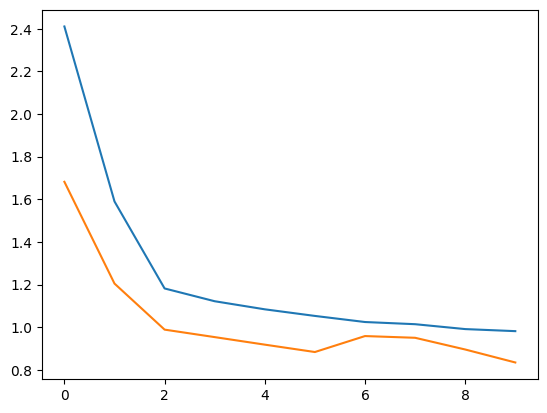

tensor(0.9715)
tensor(0.8218)
tensor(0.9429)
tensor(0.8090)
tensor(0.9429)
tensor(0.8432)
tensor(0.9353)
tensor(0.8556)
tensor(0.9145)
tensor(0.7654)
tensor(0.8979)
tensor(0.8538)
tensor(0.8965)
tensor(0.7914)
tensor(0.8812)
tensor(0.7784)
tensor(0.8867)
tensor(0.7633)
tensor(0.8441)
tensor(0.7166)


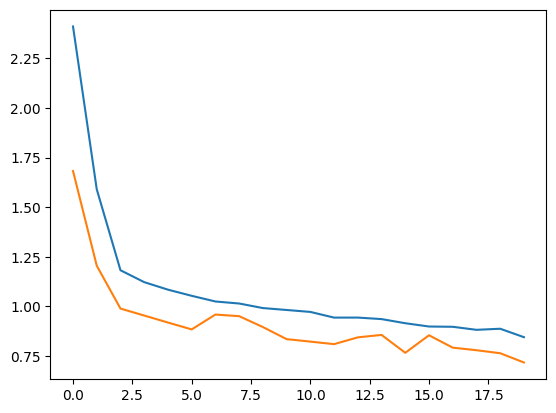

tensor(0.8358)
tensor(0.7140)
tensor(0.8252)
tensor(0.6963)
tensor(0.8151)
tensor(0.7212)
tensor(0.8088)
tensor(0.7615)
tensor(0.7909)
tensor(0.6556)
tensor(0.7714)
tensor(0.6531)
tensor(0.7532)
tensor(0.7118)
tensor(0.7545)
tensor(0.6565)
tensor(0.7343)
tensor(0.6527)
tensor(0.7289)
tensor(0.6565)


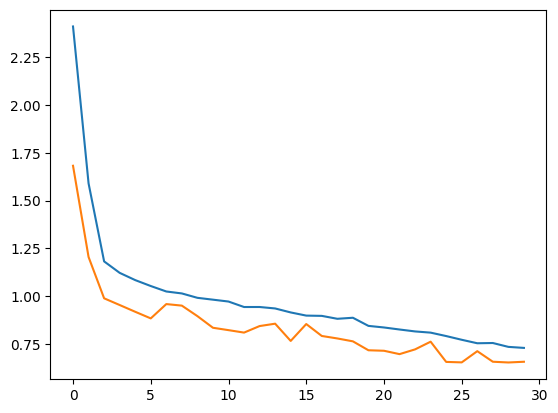

tensor(0.7145)
tensor(0.6732)
tensor(0.7149)
tensor(0.6180)
tensor(0.7097)
tensor(0.6075)
tensor(0.6765)
tensor(0.6467)
tensor(0.6857)
tensor(0.6704)
tensor(0.6677)
tensor(0.6107)
tensor(0.6748)
tensor(0.5983)
tensor(0.6480)
tensor(0.5847)
tensor(0.6417)
tensor(0.6566)
tensor(0.6404)
tensor(0.7061)


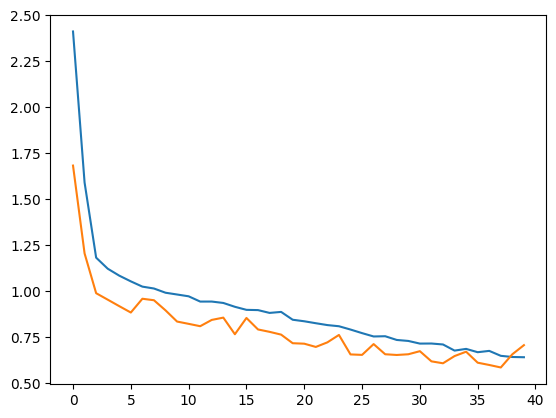

tensor(0.6411)
tensor(0.5656)
tensor(0.6263)
tensor(0.5982)
tensor(0.6154)
tensor(0.6259)
tensor(0.6191)
tensor(0.6386)
tensor(0.6168)
tensor(0.5596)
tensor(0.6104)
tensor(0.5854)
tensor(0.6098)
tensor(0.5608)
tensor(0.5915)
tensor(0.5574)
tensor(0.6037)
tensor(0.6071)
tensor(0.5859)
tensor(0.5627)


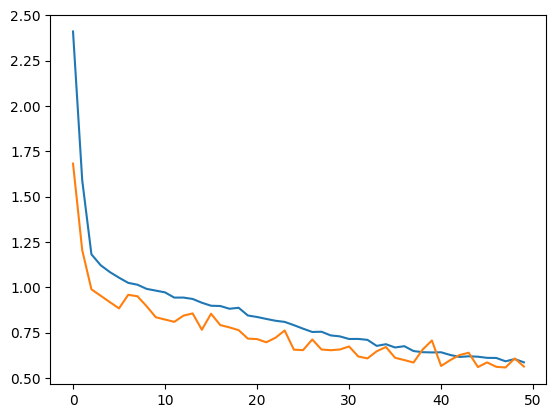

tensor(0.5792)
tensor(0.5683)
tensor(0.5809)
tensor(0.5732)
tensor(0.5749)
tensor(0.5809)
tensor(0.5805)
tensor(0.5679)
tensor(0.5779)
tensor(0.5859)
tensor(0.5578)
tensor(0.5700)
tensor(0.5681)
tensor(0.5638)
tensor(0.5519)
tensor(0.5379)
tensor(0.5639)
tensor(0.5221)
tensor(0.5509)
tensor(0.5335)


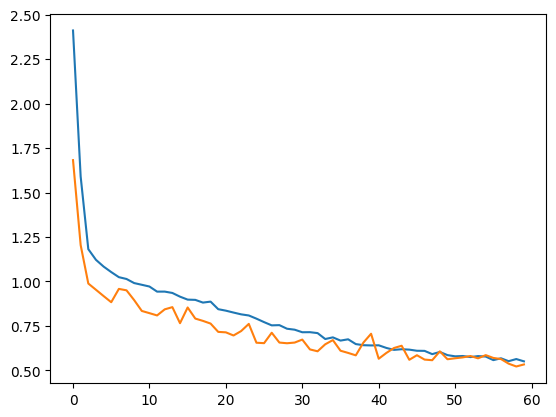

tensor(0.5595)
tensor(0.5382)
tensor(0.5471)
tensor(0.5591)
tensor(0.5431)
tensor(0.5660)
tensor(0.5411)
tensor(0.5239)
tensor(0.5468)
tensor(0.5144)
tensor(0.5344)
tensor(0.5577)
tensor(0.5398)
tensor(0.5511)
tensor(0.5357)
tensor(0.5219)
tensor(0.5420)
tensor(0.5350)
tensor(0.5238)
tensor(0.5044)


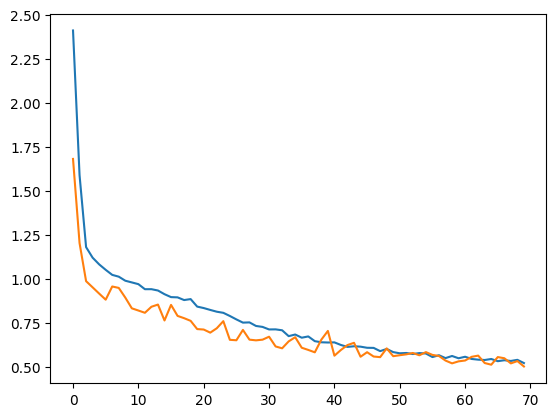

tensor(0.5279)
tensor(0.5097)
tensor(0.5229)
tensor(0.5093)
tensor(0.5204)
tensor(0.4955)
tensor(0.5136)
tensor(0.5180)
tensor(0.5185)
tensor(0.5163)
tensor(0.5116)
tensor(0.5126)
tensor(0.5172)
tensor(0.5162)
tensor(0.5146)
tensor(0.5596)
tensor(0.5175)
tensor(0.5180)
tensor(0.5060)
tensor(0.5695)


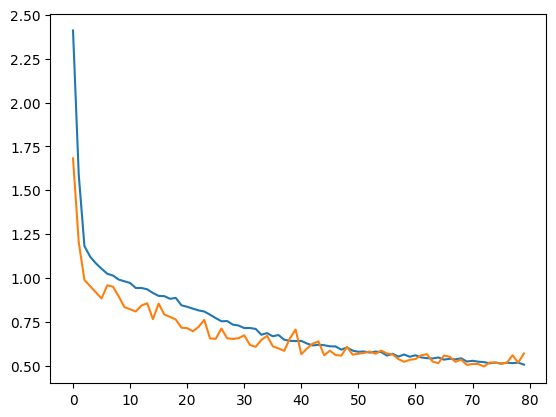

tensor(0.4969)
tensor(0.5166)
tensor(0.5128)
tensor(0.4797)
tensor(0.4991)
tensor(0.5064)
tensor(0.4874)
tensor(0.5589)
tensor(0.4947)
tensor(0.5367)
tensor(0.4842)
tensor(0.4992)
tensor(0.4927)
tensor(0.4872)
tensor(0.4853)
tensor(0.4748)
tensor(0.4924)
tensor(0.4814)
tensor(0.4753)
tensor(0.4583)


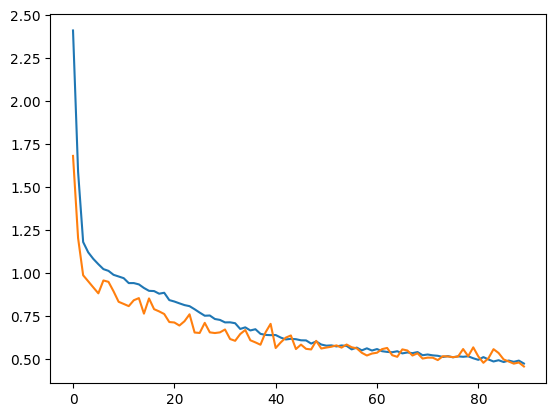

tensor(0.4736)
tensor(0.4818)
tensor(0.4637)
tensor(0.4861)
tensor(0.4692)
tensor(0.5231)
tensor(0.4580)
tensor(0.4510)
tensor(0.4628)
tensor(0.5346)
tensor(0.4535)
tensor(0.4683)
tensor(0.4424)
tensor(0.4855)
tensor(0.4473)
tensor(0.4830)
tensor(0.4367)
tensor(0.4850)
tensor(0.4430)
tensor(0.4533)


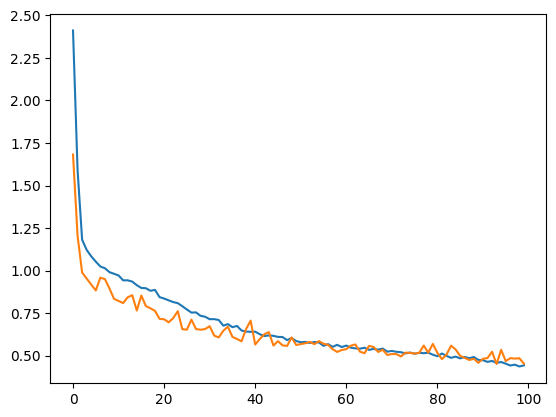

tensor(0.4301)
tensor(0.4814)
tensor(0.4348)
tensor(0.4733)
tensor(0.4262)
tensor(0.5329)
tensor(0.4339)
tensor(0.4819)
tensor(0.4356)
tensor(0.4454)
tensor(0.4208)
tensor(0.4647)
tensor(0.4275)
tensor(0.5043)
tensor(0.4129)
tensor(0.4635)
tensor(0.4199)
tensor(0.4516)
tensor(0.4237)
tensor(0.4392)


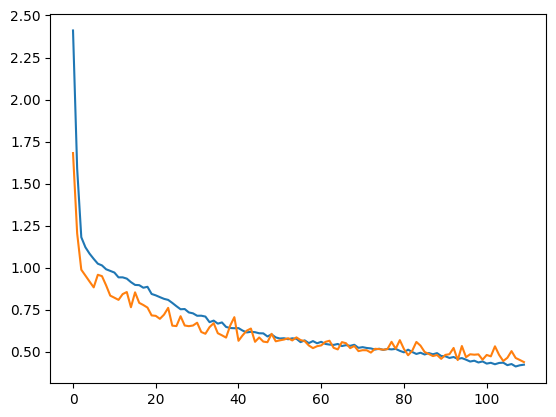

tensor(0.4209)
tensor(0.4377)
tensor(0.4080)
tensor(0.4702)
tensor(0.4091)
tensor(0.4656)
tensor(0.4203)
tensor(0.4404)
tensor(0.4022)
tensor(0.4397)
tensor(0.4075)
tensor(0.4308)
tensor(0.4037)
tensor(0.4418)
tensor(0.4061)
tensor(0.4261)
tensor(0.4028)
tensor(0.4527)
tensor(0.3984)
tensor(0.4677)


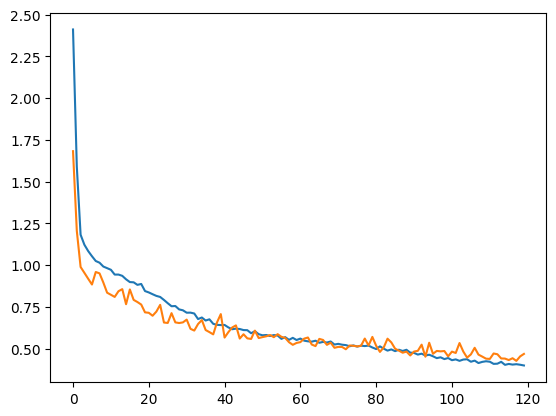

tensor(0.3890)
tensor(0.4530)
tensor(0.3843)
tensor(0.4341)
tensor(0.3946)
tensor(0.4628)
tensor(0.3946)
tensor(0.4260)
tensor(0.3908)
tensor(0.4489)
tensor(0.3850)
tensor(0.4447)
tensor(0.3830)
tensor(0.4184)
tensor(0.3898)
tensor(0.4464)
tensor(0.3905)
tensor(0.4124)
tensor(0.3880)
tensor(0.4299)


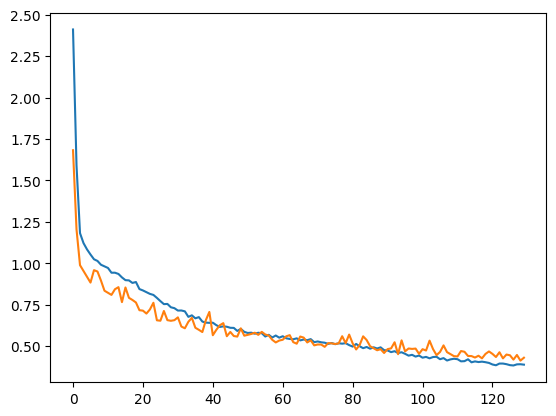

tensor(0.3838)
tensor(0.4334)
tensor(0.3859)
tensor(0.4316)
tensor(0.3917)
tensor(0.4411)
tensor(0.3813)
tensor(0.4274)
tensor(0.3745)
tensor(0.4845)
tensor(0.3714)
tensor(0.4297)
tensor(0.3750)
tensor(0.4736)
tensor(0.3765)
tensor(0.4211)
tensor(0.3793)
tensor(0.4273)
tensor(0.3655)
tensor(0.4215)


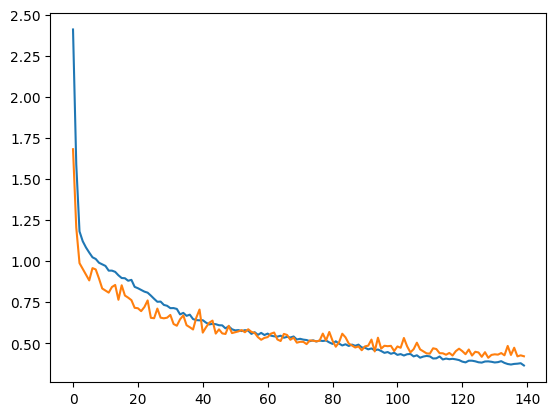

tensor(0.3744)
tensor(0.4174)
tensor(0.3684)
tensor(0.4077)
tensor(0.3662)
tensor(0.4214)
tensor(0.3710)
tensor(0.4485)
tensor(0.3617)
tensor(0.4134)
tensor(0.3668)
tensor(0.4116)
tensor(0.3628)
tensor(0.4927)
tensor(0.3648)
tensor(0.4200)
tensor(0.3567)
tensor(0.4241)
tensor(0.3605)
tensor(0.4410)


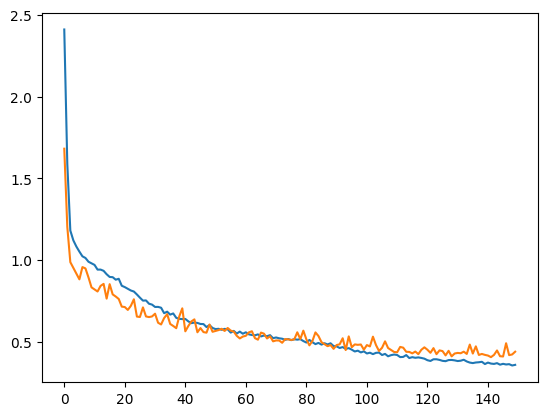

tensor(0.3601)
tensor(0.4192)
tensor(0.3640)
tensor(0.4176)
tensor(0.3600)
tensor(0.4353)
tensor(0.3560)
tensor(0.4140)
tensor(0.3547)
tensor(0.4129)
tensor(0.3490)
tensor(0.4306)
tensor(0.3547)
tensor(0.4261)
tensor(0.3587)
tensor(0.4305)
tensor(0.3467)
tensor(0.4101)
tensor(0.3508)
tensor(0.4159)


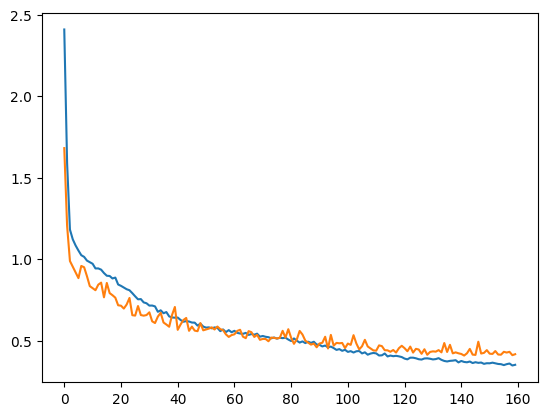

tensor(0.3470)
tensor(0.3944)
tensor(0.3466)
tensor(0.4029)
tensor(0.3462)
tensor(0.4383)
tensor(0.3466)
tensor(0.4415)
tensor(0.3478)
tensor(0.4021)
tensor(0.3450)
tensor(0.3979)
tensor(0.3456)
tensor(0.4496)
tensor(0.3423)
tensor(0.4136)
tensor(0.3408)
tensor(0.4075)
tensor(0.3394)
tensor(0.4204)


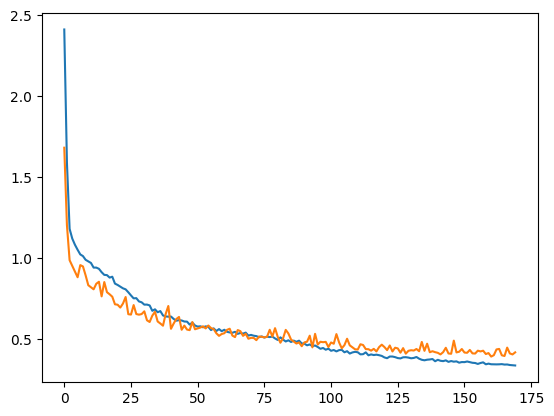

tensor(0.3368)
tensor(0.4092)
tensor(0.3360)
tensor(0.4244)
tensor(0.3396)
tensor(0.4027)
tensor(0.3381)
tensor(0.4486)
tensor(0.3370)
tensor(0.4325)
tensor(0.3305)
tensor(0.4127)
tensor(0.3355)
tensor(0.4042)
tensor(0.3339)
tensor(0.3865)
tensor(0.3276)
tensor(0.4116)
tensor(0.3322)
tensor(0.4581)


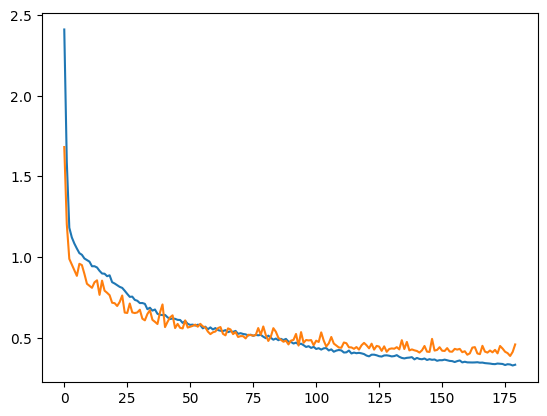

tensor(0.3386)
tensor(0.4585)
tensor(0.3364)
tensor(0.4174)
tensor(0.3364)
tensor(0.3945)
tensor(0.3274)
tensor(0.4132)
tensor(0.3256)
tensor(0.3998)
tensor(0.3344)
tensor(0.4464)
tensor(0.3352)
tensor(0.4407)
tensor(0.3269)
tensor(0.3908)
tensor(0.3165)
tensor(0.4226)
tensor(0.3224)
tensor(0.4674)


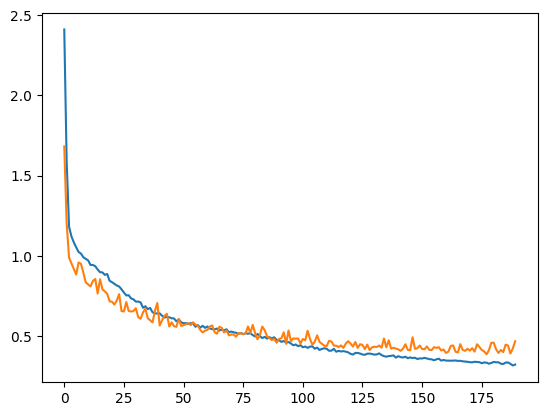

tensor(0.3249)
tensor(0.4202)
tensor(0.3299)
tensor(0.3908)
tensor(0.3208)
tensor(0.3983)
tensor(0.3184)
tensor(0.3914)
tensor(0.3156)
tensor(0.4238)
tensor(0.3192)
tensor(0.4064)
tensor(0.3181)
tensor(0.4103)
tensor(0.3191)
tensor(0.3910)
tensor(0.3144)
tensor(0.3827)
tensor(0.3161)
tensor(0.4120)


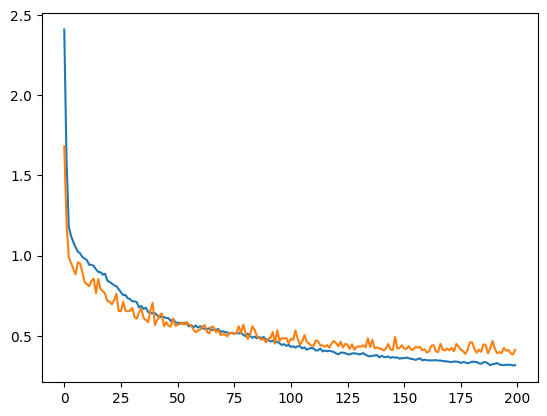

tensor(0.3175)
tensor(0.3973)
tensor(0.3138)
tensor(0.3915)
tensor(0.3123)
tensor(0.3911)
tensor(0.3174)
tensor(0.4147)
tensor(0.3173)
tensor(0.4008)
tensor(0.3051)
tensor(0.3895)
tensor(0.3114)
tensor(0.4021)
tensor(0.3100)
tensor(0.3965)
tensor(0.3093)
tensor(0.3913)
tensor(0.3062)
tensor(0.3972)


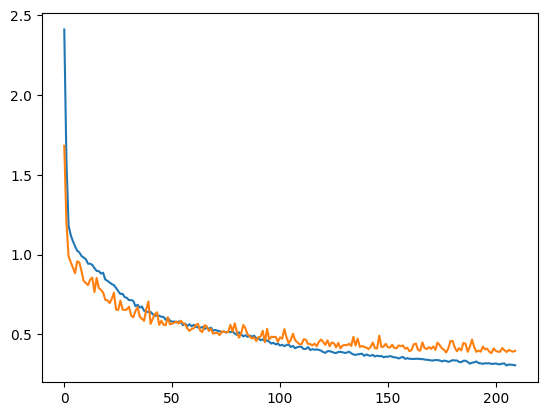

tensor(0.3084)
tensor(0.3886)
tensor(0.3147)
tensor(0.3851)
tensor(0.3124)
tensor(0.3948)
tensor(0.3091)
tensor(0.3816)
tensor(0.3034)
tensor(0.3878)
tensor(0.2996)
tensor(0.4025)
tensor(0.3002)
tensor(0.4179)
tensor(0.3076)
tensor(0.4049)
tensor(0.2987)
tensor(0.4077)
tensor(0.3033)
tensor(0.4048)


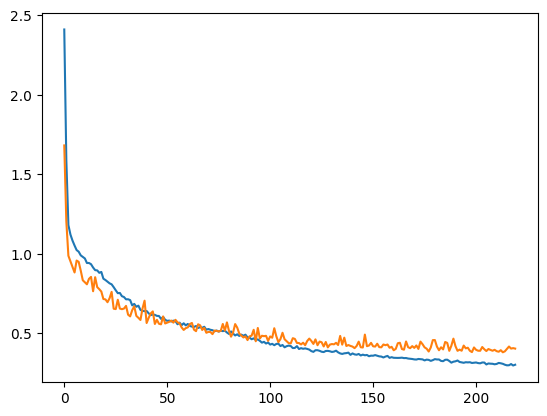

tensor(0.2963)
tensor(0.4044)
tensor(0.2972)
tensor(0.3841)
tensor(0.2972)
tensor(0.4014)
tensor(0.3017)
tensor(0.4084)
tensor(0.2963)
tensor(0.3876)
tensor(0.2977)
tensor(0.3989)
tensor(0.2977)
tensor(0.4014)
tensor(0.2913)
tensor(0.3953)
tensor(0.2916)
tensor(0.3985)
tensor(0.2993)
tensor(0.3807)


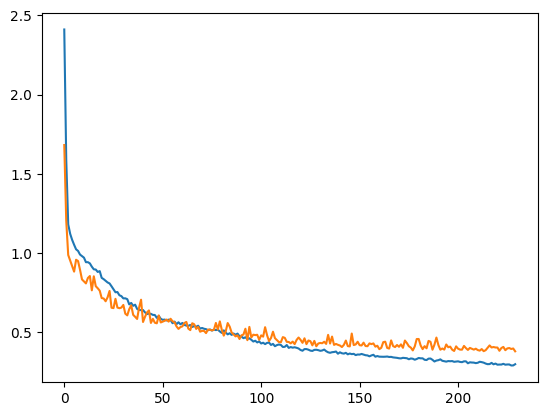

tensor(0.2994)
tensor(0.4239)
tensor(0.3021)
tensor(0.3895)
tensor(0.2931)
tensor(0.3923)
tensor(0.2931)
tensor(0.3888)
tensor(0.2886)
tensor(0.4174)
tensor(0.2956)
tensor(0.4072)
tensor(0.2867)
tensor(0.3793)
tensor(0.2951)
tensor(0.4052)
tensor(0.2888)
tensor(0.3970)
tensor(0.2929)
tensor(0.4132)


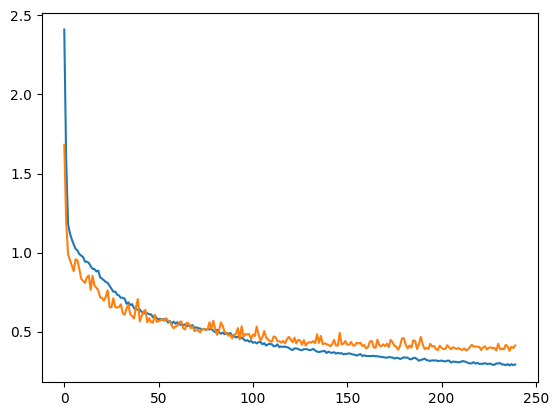

tensor(0.2915)
tensor(0.3859)
tensor(0.2853)
tensor(0.3800)
tensor(0.2837)
tensor(0.3832)
tensor(0.2856)
tensor(0.3804)
tensor(0.2832)
tensor(0.3869)
tensor(0.2892)
tensor(0.4297)
tensor(0.2875)
tensor(0.4069)
tensor(0.2812)
tensor(0.3861)
tensor(0.2870)
tensor(0.3913)
tensor(0.2835)
tensor(0.3858)


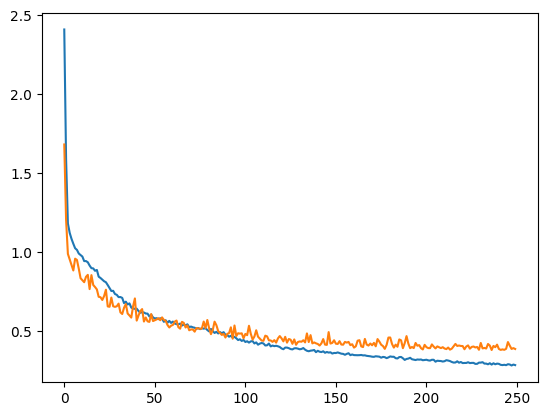

tensor(0.2819)
tensor(0.3900)
tensor(0.2829)
tensor(0.4173)
tensor(0.2847)
tensor(0.3855)
tensor(0.2769)
tensor(0.3750)
tensor(0.2747)
tensor(0.3782)
tensor(0.2838)
tensor(0.3825)
tensor(0.2789)
tensor(0.4062)
tensor(0.2802)
tensor(0.3838)
tensor(0.2798)
tensor(0.3801)
tensor(0.2789)
tensor(0.3818)


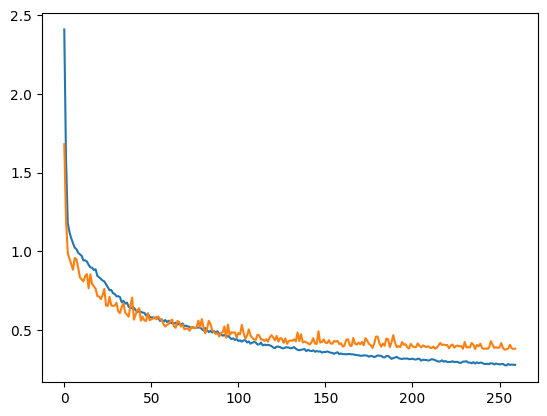

tensor(0.2790)
tensor(0.3734)
tensor(0.2827)
tensor(0.3958)
tensor(0.2805)
tensor(0.3965)
tensor(0.2782)
tensor(0.3834)
tensor(0.2776)
tensor(0.3873)
tensor(0.2810)
tensor(0.4087)
tensor(0.2733)
tensor(0.3762)
tensor(0.2727)
tensor(0.3916)
tensor(0.2764)
tensor(0.3891)
tensor(0.2680)
tensor(0.3705)


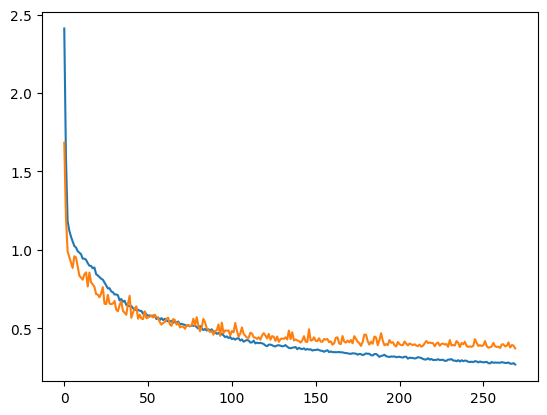

tensor(0.2703)
tensor(0.4067)
tensor(0.2795)
tensor(0.3925)
tensor(0.2733)
tensor(0.3680)
tensor(0.2782)
tensor(0.3690)
tensor(0.2696)
tensor(0.4047)
tensor(0.2685)
tensor(0.3950)
tensor(0.2688)
tensor(0.4189)
tensor(0.2779)
tensor(0.4503)
tensor(0.2705)
tensor(0.3767)
tensor(0.2673)
tensor(0.4315)


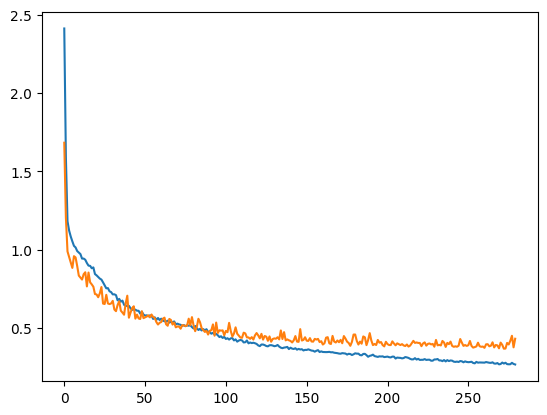

tensor(0.2654)
tensor(0.3720)
tensor(0.2679)
tensor(0.3908)
tensor(0.2649)
tensor(0.3737)
tensor(0.2664)
tensor(0.3808)
tensor(0.2623)
tensor(0.3886)
tensor(0.2636)
tensor(0.3889)
tensor(0.2657)
tensor(0.3920)
tensor(0.2676)
tensor(0.3877)
tensor(0.2741)
tensor(0.3777)
tensor(0.2664)
tensor(0.3999)


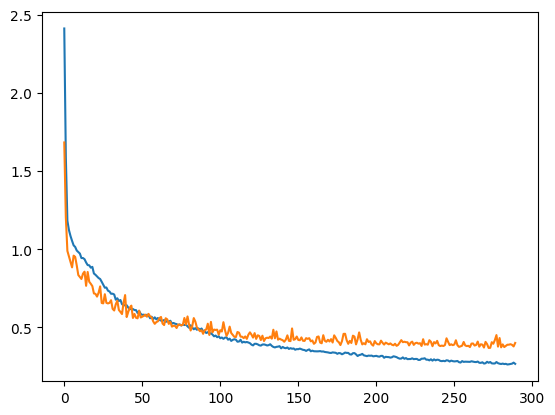

tensor(0.2638)
tensor(0.3925)
tensor(0.2603)
tensor(0.3850)
tensor(0.2652)
tensor(0.3985)
tensor(0.2600)
tensor(0.3804)
tensor(0.2593)
tensor(0.3887)
tensor(0.2580)
tensor(0.3760)
tensor(0.2632)
tensor(0.3718)
tensor(0.2588)
tensor(0.3810)
tensor(0.2645)
tensor(0.3753)
tensor(0.2585)
tensor(0.3722)


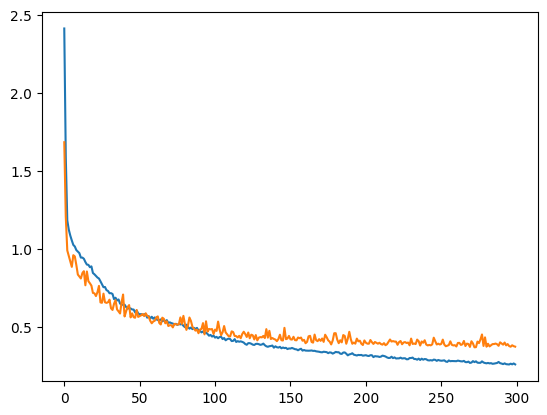

In [123]:
loss_log = []
loss_log_val = []
for epoch in range(90):
  tl = 0
  tl_val=0
  model.train()
  for b in loaded_train:
    l =  train(b)
    tl += l
  model.eval()
  for b in loaded_val:
    l = test(b)
    tl_val += l
  print(tl/len(loaded_train))
  print(tl_val/len(loaded_val))
  loss_log.append(tl/len(loaded_train))
  loss_log_val.append(tl_val/len(loaded_val))
  if epoch%10==9:
    plt.plot(loss_log[1:])
    plt.plot(loss_log_val[1:])
    plt.show()

In [95]:
ys = [s.y0 for s in data_list]
print(max(ys))
print(min(ys))
print(np.mean(ys))
print(np.std(ys))
print(np.median(ys))

tensor(18.6915)
tensor(0.)
2.5120122
1.4246941
2.2976


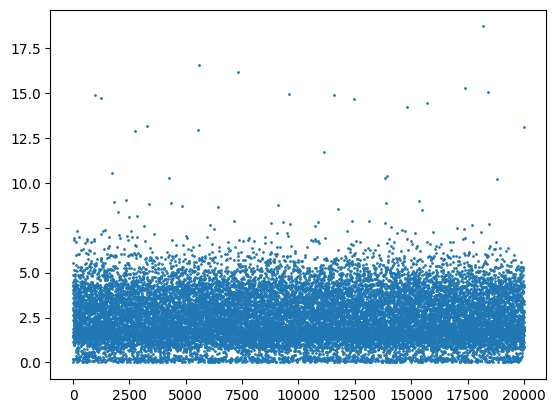

In [97]:
plt.scatter(np.arange(len(ys)),ys, s=1)

In [ ]:
right = 0
wrong = 0
ok =0
errors = []
std = np.std(ys)
for s in data_test:
  model.eval()
  pred, enc = model(s.x,s.edge_index, s.batch)
  #print(pred.detach().numpy(), s.y.numpy())
  error = np.abs(pred.detach().numpy()-s.y0.numpy())
  errors.append(error)
  if error <std/5:
    right+=1
  elif error<std/2:
    ok+=1
  else:
    wrong+=1
print(right, ok, wrong)

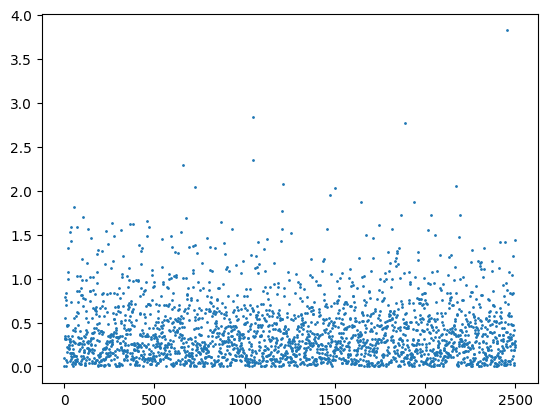

In [98]:
plt.scatter(np.arange(len(errors)),errors/np.std(ys), s=1)

In [17]:
encodings = np.zeros(20000)
data_list

[Data(x=[17, 4], edge_index=[2, 34], y0=5.5391998291015625, y1=68.6500015258789, y2=-7.186526775360107, y3=0.7102171778678894, id=10400),
 Data(x=[17, 4], edge_index=[2, 36], y0=1.8278000354766846, y1=75.63999938964844, y2=-6.533453464508057, y3=0.9632830619812012, id=13676),
 Data(x=[20, 4], edge_index=[2, 44], y0=0.21629999577999115, y1=78.4800033569336, y2=-7.477688789367676, y3=2.4871206283569336, id=14130),
 Data(x=[16, 4], edge_index=[2, 34], y0=2.1249001026153564, y1=64.55000305175781, y2=-6.435492515563965, y3=-0.5687179565429688, id=12688),
 Data(x=[17, 4], edge_index=[2, 32], y0=2.927999973297119, y1=60.84000015258789, y2=-7.151152610778809, y3=-0.6639577746391296, id=1609),
 Data(x=[17, 4], edge_index=[2, 36], y0=3.874500036239624, y1=71.0999984741211, y2=-6.411002159118652, y3=0.17415286600589752, id=12616),
 Data(x=[22, 4], edge_index=[2, 44], y0=1.527400016784668, y1=77.47000122070312, y2=-6.54978084564209, y3=2.0979979038238525, id=6418),
 Data(x=[19, 4], edge_index=[2, 

In [19]:
model.eval()
for b in data_list:
  pred, enc = model(b.x,b.edge_index, b.batch)
  b.enc = enc.detach()

Streaming output truncated to the last 5000 lines.
tensor([[ 7.6805, 11.0742,  2.3720,  2.5592,  5.9814,  6.5806,  4.9861,  3.2793,
          2.4688,  3.2370,  3.6149,  2.1661]])
tensor([[ 5.3318, 10.7448,  1.9172,  2.6402,  5.9381,  5.4869,  7.6704,  3.1892,
          1.8736,  2.7345,  2.8606,  1.6127]])
tensor([[ 8.5988, 11.5452,  2.4056,  2.8069,  6.4102,  6.7719,  5.9481,  4.1937,
          2.3158,  2.9550,  3.8332,  2.2156]])
tensor([[7.7122, 8.9656, 1.6905, 1.5496, 4.7964, 5.0331, 3.5722, 2.6959, 1.6344,
         2.5796, 2.3236, 1.4469]])
tensor([[ 8.6145, 14.8990,  3.0558,  4.4192,  7.5143,  8.0779,  9.0413,  4.5818,
          3.4565,  3.8794,  5.3725,  3.0877]])
tensor([[ 6.4869, 10.6445,  2.3929,  3.1877,  5.4264,  6.0826,  5.2142,  3.5751,
          2.7830,  3.1957,  4.4495,  2.5616]])
tensor([[ 7.1819, 11.9339,  2.4140,  3.4179,  6.5144,  6.8462,  9.4147,  4.0275,
          2.5702,  3.1590,  4.1549,  2.3653]])
tensor([[ 7.7394, 12.6685,  2.5652,  3.6198,  6.6639,  6.9754,  7

In [21]:
random.shuffle(data_list)

In [79]:
class predictor(nn.Module):
    def __init__(self, in_channels = 12):
        super(predictor, self).__init__()
        self.regression = nn.Sequential(nn.Linear(12, 16), nn.ReLU(), nn.Linear(16, 32),nn.ReLU(),nn.Linear(32, 8),nn.ReLU(),nn.Linear(8, 1))

    def forward(self, enc):
        pred = self.regression(enc)
        #print(np.shape(pred))
        #print('pred =')
        #print(pred)
        return pred

In [80]:
data_train1 = data_list[:15000]
data_val1 = data_list[15000:17500]
data_test1 = data_list[17500:]
loaded_train1 = DataLoader(data_train1, batch_size=50, shuffle=True)
loaded_val1 = DataLoader(data_val1, batch_size=50, shuffle=True)
loaded_test1 = DataLoader(data_test1, batch_size=50, shuffle=True)
model1 = predictor()
#optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model1.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
print(model1)


predictor(
  (regression): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [81]:
def train1(b):
  p = model1(b.enc)
  #print(np.shape(p))
  #print(b.enc)
  #print(p)
  l = loss_fn(p, b.y1.reshape((50,1)))
  #print(b.y1.reshape((50,1)))
  #print(pred)
  optimizer.zero_grad()
  l.backward()
  optimizer.step()
  return l.detach()
def test1(b):
  p = model1(b.enc)
  l = loss_fn(p, b.y1.reshape((50,1)))
  return l.detach()

tensor(1132.7664)
tensor(36.7692)
tensor(33.4617)
tensor(32.2229)
tensor(28.5958)
tensor(27.4223)
tensor(25.1522)
tensor(25.1824)
tensor(23.4364)
tensor(23.7654)
tensor(22.3332)
tensor(22.6814)
tensor(21.6268)
tensor(22.2967)
tensor(21.0320)
tensor(21.5197)
tensor(20.5784)
tensor(21.1662)
tensor(20.2618)
tensor(20.7102)
tensor(19.8407)
tensor(20.4445)
tensor(19.5623)
tensor(19.8791)
tensor(19.3016)
tensor(19.4796)
tensor(18.8342)
tensor(19.3239)
tensor(18.4610)
tensor(18.7948)
tensor(18.1216)
tensor(18.5871)
tensor(17.8848)
tensor(18.2239)
tensor(17.7037)
tensor(17.8805)
tensor(17.4211)
tensor(17.6208)
tensor(17.2985)
tensor(17.6475)


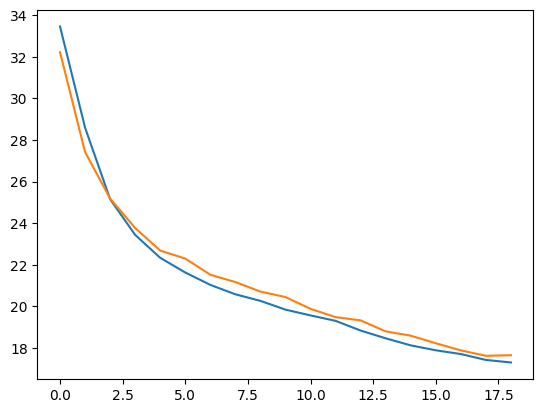

tensor(17.0463)
tensor(17.2186)
tensor(17.0517)
tensor(18.6655)
tensor(16.5866)
tensor(16.9097)
tensor(16.5762)
tensor(17.6967)
tensor(16.4462)
tensor(16.7479)
tensor(16.3130)
tensor(16.6847)
tensor(16.3494)
tensor(16.6778)
tensor(16.1662)
tensor(16.7311)
tensor(16.1132)
tensor(17.3546)
tensor(15.9602)
tensor(16.1191)
tensor(15.9441)
tensor(16.0383)
tensor(15.8977)
tensor(16.9245)
tensor(15.8065)
tensor(15.8655)
tensor(15.5978)
tensor(15.8732)
tensor(15.5698)
tensor(15.7534)
tensor(15.4881)
tensor(15.8171)
tensor(15.4616)
tensor(15.7907)
tensor(15.4207)
tensor(15.5568)
tensor(15.3676)
tensor(15.5859)
tensor(15.2697)
tensor(15.8202)


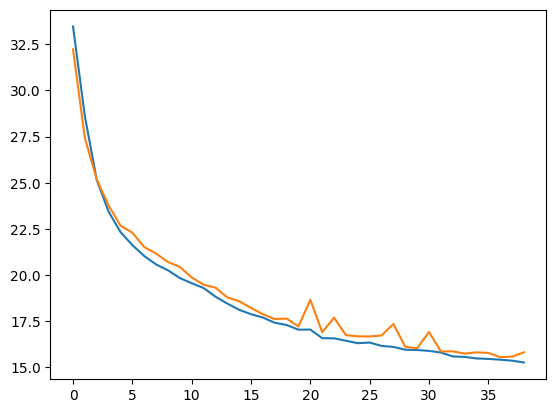

tensor(15.4669)
tensor(15.3546)
tensor(15.1463)
tensor(15.2087)
tensor(15.2077)
tensor(15.3023)
tensor(15.0431)
tensor(15.4211)
tensor(15.0572)
tensor(15.1053)
tensor(14.8485)
tensor(15.4202)
tensor(14.9008)
tensor(15.0262)
tensor(14.8786)
tensor(15.4047)
tensor(14.6867)
tensor(15.2508)
tensor(14.6620)
tensor(14.7073)
tensor(14.5402)
tensor(14.5632)
tensor(14.4347)
tensor(14.4376)
tensor(14.4589)
tensor(14.5983)
tensor(14.2839)
tensor(14.3663)
tensor(14.3045)
tensor(14.7728)
tensor(14.0538)
tensor(14.1750)
tensor(14.0411)
tensor(14.2569)
tensor(13.9244)
tensor(14.3668)
tensor(13.9062)
tensor(14.2228)
tensor(13.8833)
tensor(14.0278)


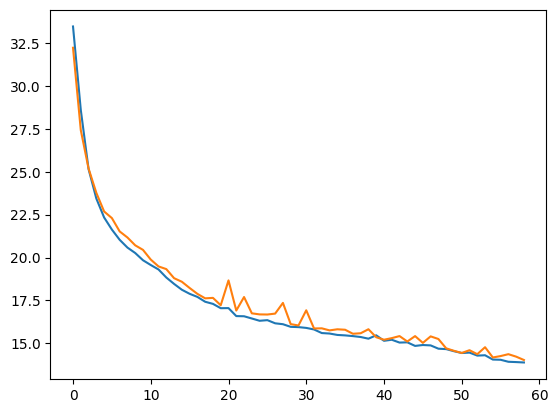

tensor(13.8204)
tensor(14.4010)
tensor(13.6580)
tensor(13.9548)
tensor(13.5454)
tensor(13.7158)
tensor(13.5314)
tensor(14.4933)
tensor(13.5688)
tensor(13.5649)
tensor(13.4088)
tensor(13.4989)
tensor(13.4100)
tensor(13.6904)
tensor(13.2260)
tensor(13.8325)
tensor(13.2727)
tensor(14.1002)
tensor(13.4013)
tensor(13.4888)
tensor(13.1579)
tensor(13.4077)
tensor(13.2253)
tensor(13.8548)
tensor(13.2465)
tensor(13.2442)
tensor(13.1791)
tensor(13.2189)
tensor(13.1492)
tensor(13.6404)
tensor(13.0654)
tensor(13.4418)
tensor(13.0008)
tensor(13.3546)
tensor(13.0122)
tensor(13.7649)
tensor(13.1401)
tensor(13.0882)
tensor(13.0724)
tensor(13.3019)


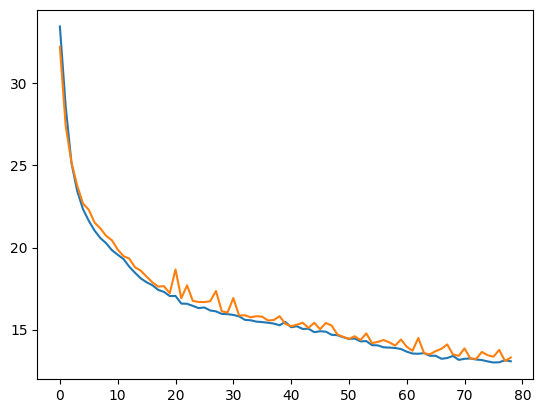

tensor(12.9162)
tensor(13.4610)
tensor(13.0312)
tensor(13.1281)
tensor(12.9130)
tensor(13.4767)
tensor(12.9689)
tensor(13.1140)
tensor(12.9983)
tensor(13.1855)
tensor(12.8075)
tensor(12.9870)
tensor(12.8401)
tensor(13.0797)
tensor(12.7979)
tensor(12.9154)
tensor(12.9580)
tensor(13.2138)
tensor(13.0719)
tensor(13.1012)
tensor(12.7818)
tensor(12.9433)
tensor(12.8432)
tensor(13.4809)
tensor(12.8537)
tensor(13.2579)
tensor(12.8634)
tensor(12.8721)
tensor(13.0062)
tensor(13.1051)
tensor(12.8288)
tensor(12.8103)
tensor(12.7343)
tensor(13.1056)
tensor(12.7615)
tensor(12.9613)
tensor(12.7824)
tensor(12.9414)
tensor(12.7465)
tensor(13.3134)


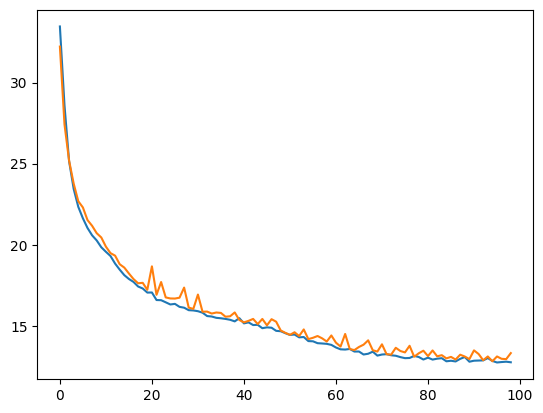

tensor(12.6543)
tensor(12.8840)
tensor(12.7586)
tensor(15.2787)
tensor(12.7062)
tensor(13.1024)
tensor(12.6332)
tensor(12.7841)
tensor(12.7863)
tensor(12.7430)
tensor(12.6058)
tensor(13.6676)
tensor(12.7417)
tensor(13.0442)
tensor(12.6298)
tensor(13.0335)
tensor(12.6351)
tensor(13.4629)
tensor(12.5908)
tensor(13.1345)
tensor(12.6912)
tensor(13.2507)
tensor(12.6655)
tensor(13.4117)
tensor(12.5923)
tensor(12.9120)
tensor(12.5975)
tensor(12.8761)
tensor(12.5178)
tensor(12.7954)
tensor(12.5857)
tensor(12.7315)
tensor(12.5704)
tensor(12.9805)
tensor(12.5051)
tensor(12.9908)
tensor(12.5221)
tensor(12.9398)
tensor(12.4643)
tensor(12.9904)


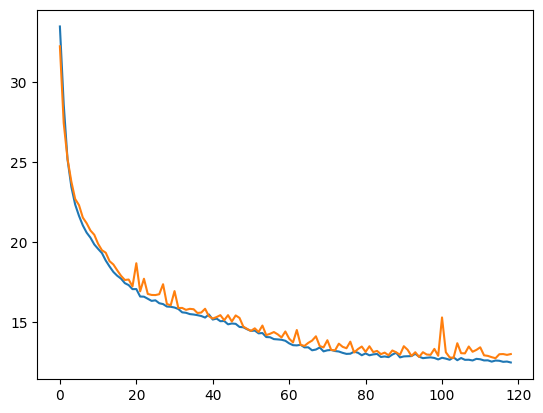

tensor(12.5412)
tensor(12.8463)
tensor(12.4357)
tensor(12.6273)
tensor(12.4894)
tensor(12.6003)
tensor(12.4167)
tensor(14.1532)
tensor(12.5656)
tensor(12.7367)
tensor(12.4994)
tensor(12.8798)
tensor(12.3963)
tensor(12.5694)
tensor(12.5387)
tensor(12.6197)
tensor(12.4681)
tensor(13.3243)
tensor(12.2989)
tensor(12.7700)
tensor(12.3916)
tensor(12.5893)
tensor(12.3798)
tensor(12.9122)
tensor(12.4345)
tensor(13.0996)
tensor(12.6861)
tensor(12.4851)
tensor(12.3723)
tensor(12.4066)
tensor(12.4233)
tensor(12.5956)
tensor(12.4390)
tensor(12.9340)
tensor(12.3943)
tensor(12.5249)
tensor(12.3057)
tensor(12.7753)
tensor(12.3640)
tensor(12.4423)


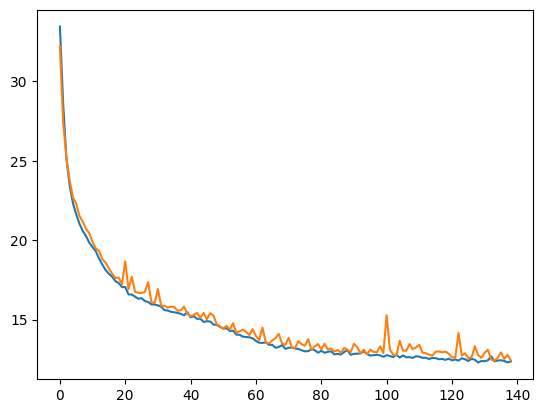

tensor(12.3256)
tensor(12.5090)
tensor(12.4337)
tensor(12.8055)
tensor(12.4881)
tensor(12.9879)
tensor(12.2536)
tensor(12.4117)
tensor(12.2700)
tensor(12.4029)
tensor(12.3815)
tensor(12.4718)
tensor(12.3056)
tensor(12.5856)
tensor(12.5326)
tensor(15.7041)
tensor(12.3539)
tensor(12.5497)
tensor(12.2989)
tensor(12.8542)
tensor(12.2019)
tensor(12.6775)
tensor(12.3102)
tensor(12.6129)
tensor(12.1973)
tensor(12.9351)
tensor(12.2459)
tensor(12.3296)
tensor(12.1657)
tensor(12.6236)
tensor(12.1912)
tensor(12.3137)
tensor(12.1929)
tensor(12.5936)
tensor(12.2161)
tensor(12.4791)
tensor(12.2338)
tensor(12.8561)
tensor(12.2346)
tensor(12.3383)


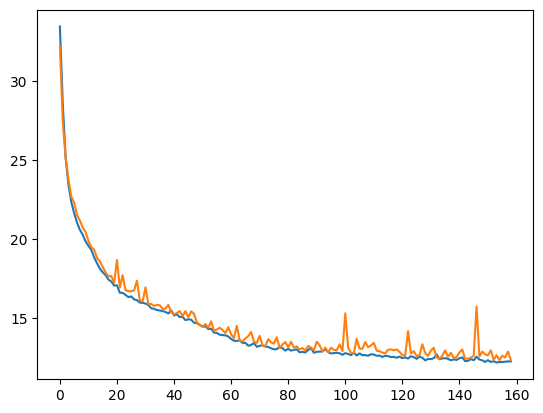

tensor(12.1745)
tensor(12.3252)
tensor(12.1794)
tensor(12.6563)
tensor(12.0673)
tensor(12.3196)
tensor(12.0886)
tensor(12.5820)
tensor(12.3569)
tensor(12.7167)
tensor(12.0932)
tensor(12.2850)
tensor(12.0658)
tensor(12.9753)
tensor(12.1025)
tensor(12.2195)
tensor(12.0775)
tensor(12.3534)
tensor(12.2659)
tensor(12.5101)
tensor(12.0971)
tensor(16.0059)
tensor(12.1377)
tensor(12.6378)
tensor(11.9748)
tensor(12.0784)
tensor(11.9998)
tensor(12.3188)
tensor(12.0509)
tensor(12.4878)
tensor(12.0536)
tensor(12.0467)
tensor(11.9620)
tensor(12.0333)
tensor(11.9507)
tensor(12.0491)
tensor(11.9607)
tensor(12.2518)
tensor(12.1127)
tensor(12.0193)


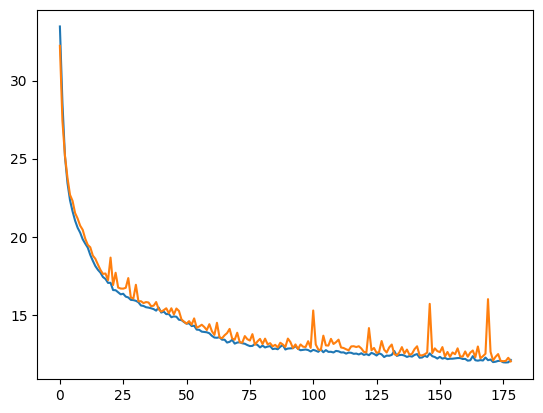

tensor(11.9818)
tensor(11.9364)
tensor(11.8724)
tensor(11.9700)
tensor(11.8331)
tensor(12.5324)
tensor(11.9777)
tensor(12.0629)
tensor(11.9385)
tensor(11.8665)
tensor(12.1959)
tensor(12.2065)
tensor(11.8771)
tensor(12.1123)
tensor(11.9664)
tensor(11.9120)
tensor(11.9198)
tensor(12.5572)
tensor(11.6977)
tensor(12.1004)
tensor(11.7710)
tensor(11.9982)
tensor(11.7765)
tensor(12.1109)
tensor(11.6805)
tensor(11.8684)
tensor(11.6424)
tensor(11.8864)
tensor(11.7246)
tensor(11.9793)
tensor(11.5960)
tensor(11.6164)
tensor(11.4391)
tensor(11.6619)
tensor(11.4221)
tensor(11.3197)
tensor(11.3761)
tensor(11.4946)
tensor(11.3037)
tensor(11.3619)


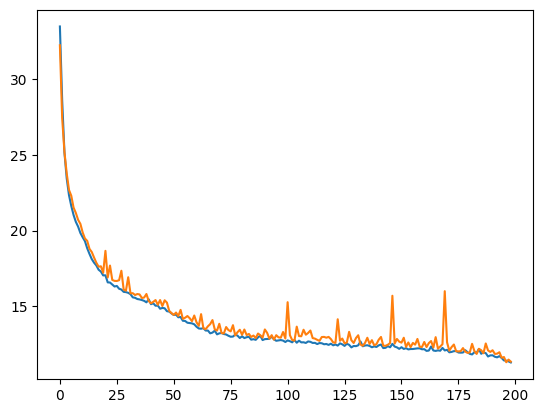

tensor(11.2235)
tensor(11.2624)
tensor(11.0726)
tensor(11.7781)
tensor(11.1367)
tensor(12.2383)
tensor(10.9833)
tensor(10.9392)
tensor(10.7737)
tensor(10.9818)
tensor(10.8595)
tensor(11.9010)
tensor(10.7374)
tensor(11.4359)
tensor(10.6112)
tensor(10.6025)
tensor(10.6119)
tensor(10.7294)
tensor(10.7653)
tensor(11.3343)
tensor(10.6133)
tensor(10.7981)
tensor(10.5179)
tensor(10.3696)
tensor(10.3907)
tensor(10.6928)
tensor(10.4340)
tensor(10.4024)
tensor(10.4000)
tensor(10.5068)
tensor(10.2032)
tensor(11.0217)
tensor(10.2138)
tensor(10.6020)
tensor(10.2841)
tensor(10.8414)
tensor(10.1444)
tensor(10.3044)
tensor(10.1092)
tensor(10.4874)


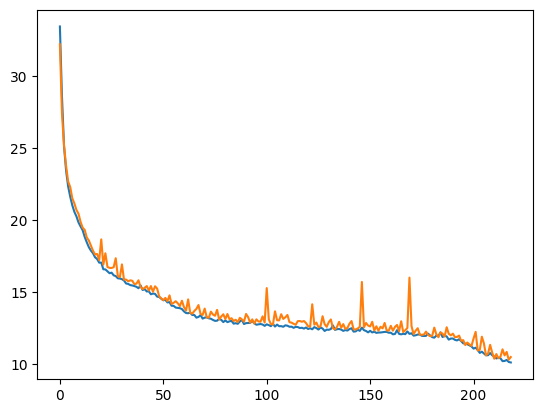

tensor(10.2048)
tensor(10.0705)
tensor(10.0635)
tensor(10.3359)
tensor(9.9807)
tensor(10.4351)
tensor(10.1701)
tensor(10.4594)
tensor(9.9309)
tensor(10.6713)
tensor(9.9503)
tensor(10.2246)
tensor(10.0195)
tensor(10.1744)
tensor(9.9623)
tensor(9.8169)
tensor(9.9330)
tensor(10.2056)
tensor(9.8086)
tensor(10.8974)
tensor(9.8619)
tensor(10.0458)
tensor(9.9339)
tensor(11.1169)
tensor(9.9088)
tensor(10.3728)
tensor(9.7990)
tensor(9.8105)
tensor(9.8800)
tensor(9.6373)
tensor(9.8474)
tensor(9.8415)
tensor(9.7395)
tensor(9.8507)
tensor(9.6500)
tensor(9.9745)
tensor(9.7920)
tensor(10.4516)
tensor(9.8374)
tensor(9.7442)


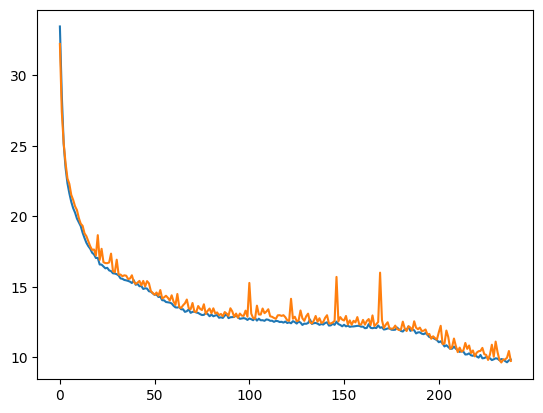

tensor(9.6350)
tensor(9.5779)
tensor(9.7058)
tensor(9.9953)
tensor(9.7177)
tensor(9.9256)
tensor(9.6864)
tensor(9.7614)
tensor(9.8801)
tensor(9.5662)
tensor(9.6085)
tensor(9.5133)
tensor(9.7710)
tensor(9.5906)
tensor(9.6515)
tensor(10.2140)
tensor(9.8401)
tensor(9.5384)
tensor(9.5426)
tensor(9.8183)
tensor(9.6122)
tensor(9.8793)
tensor(9.4784)
tensor(9.8922)
tensor(9.6576)
tensor(10.6702)
tensor(9.6486)
tensor(9.8877)
tensor(9.5474)
tensor(9.4243)
tensor(9.5642)
tensor(9.8541)
tensor(9.5866)
tensor(9.4999)
tensor(9.5024)
tensor(10.1490)
tensor(9.6323)
tensor(9.3814)
tensor(9.5191)
tensor(9.6474)


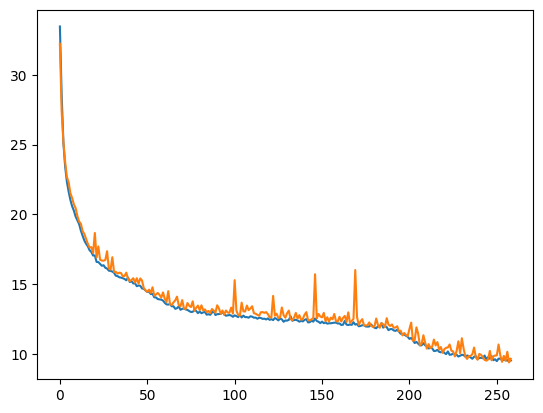

tensor(9.5173)
tensor(9.5054)
tensor(9.3462)
tensor(9.5155)
tensor(9.4780)
tensor(9.5100)
tensor(9.5457)
tensor(9.6940)
tensor(9.3517)
tensor(11.2500)
tensor(9.3897)
tensor(9.6655)
tensor(9.3130)
tensor(9.5568)
tensor(9.4000)
tensor(9.2807)
tensor(9.4280)
tensor(9.6371)
tensor(9.3652)
tensor(9.4847)
tensor(9.4315)
tensor(9.6714)
tensor(9.3866)
tensor(9.5493)
tensor(9.5436)
tensor(9.3363)
tensor(9.5171)
tensor(9.6860)
tensor(9.3685)
tensor(9.2216)
tensor(9.2500)
tensor(9.3854)
tensor(9.2270)
tensor(9.4054)
tensor(9.2975)
tensor(9.6333)
tensor(9.4371)
tensor(9.6233)
tensor(9.2761)
tensor(9.2059)


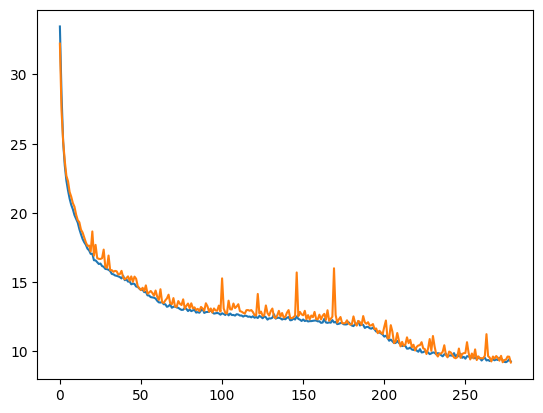

tensor(9.3827)
tensor(9.4194)
tensor(9.2215)
tensor(9.6041)
tensor(9.3213)
tensor(9.4269)
tensor(9.2319)
tensor(9.1093)
tensor(9.1959)
tensor(9.2940)
tensor(9.1097)
tensor(9.4563)
tensor(9.2365)
tensor(9.7304)
tensor(9.1838)
tensor(9.3116)
tensor(9.2807)
tensor(11.6547)
tensor(9.2492)
tensor(9.4083)
tensor(9.1024)
tensor(9.6758)
tensor(9.0854)
tensor(9.1070)
tensor(9.1838)
tensor(9.1030)
tensor(9.1324)
tensor(10.0444)
tensor(9.1321)
tensor(9.1067)
tensor(9.1309)
tensor(9.0317)
tensor(9.0330)
tensor(10.1680)
tensor(9.1514)
tensor(9.0007)
tensor(9.0680)
tensor(9.1414)
tensor(8.9909)
tensor(9.1100)


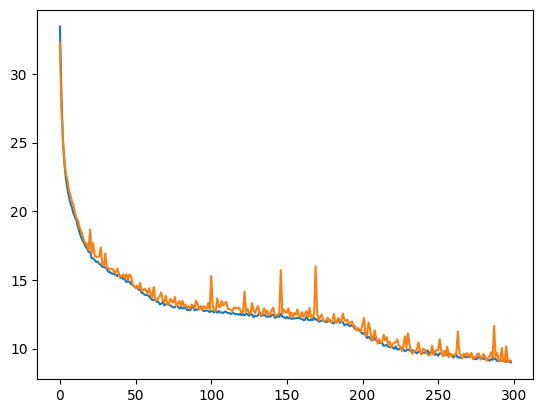

tensor(9.1220)
tensor(12.0035)
tensor(9.1909)
tensor(9.2579)
tensor(9.1487)
tensor(9.4000)
tensor(8.9146)
tensor(8.9732)
tensor(9.0649)
tensor(9.4241)
tensor(9.0186)
tensor(8.9827)
tensor(8.8199)
tensor(10.4519)
tensor(8.9259)
tensor(9.0073)
tensor(8.9820)
tensor(9.0668)
tensor(8.9302)
tensor(8.9592)
tensor(8.8726)
tensor(8.9239)
tensor(8.8587)
tensor(8.9077)
tensor(8.8903)
tensor(9.5693)
tensor(8.9409)
tensor(8.8639)
tensor(9.0118)
tensor(9.3882)
tensor(8.9654)
tensor(9.6614)
tensor(8.8520)
tensor(8.9435)
tensor(8.9984)
tensor(9.8064)
tensor(8.7325)
tensor(9.1110)
tensor(8.7520)
tensor(9.2990)


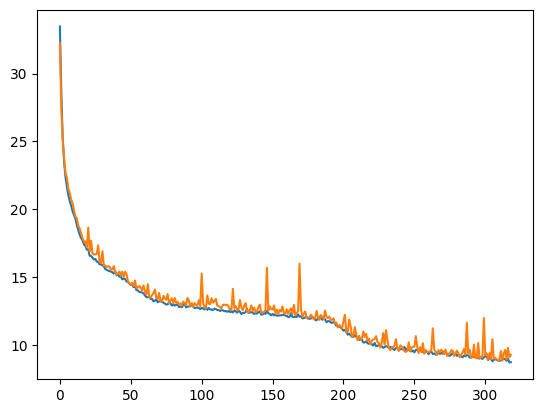

tensor(8.8591)
tensor(8.8778)
tensor(8.8005)
tensor(9.3586)
tensor(8.7578)
tensor(9.3024)
tensor(8.7055)
tensor(8.9323)
tensor(8.8636)
tensor(8.9496)
tensor(8.7369)
tensor(10.6609)
tensor(8.8648)
tensor(8.9032)
tensor(8.7898)
tensor(9.5311)
tensor(8.6901)
tensor(9.1657)
tensor(8.6755)
tensor(8.6963)
tensor(8.6482)
tensor(8.7812)
tensor(8.7020)
tensor(9.1781)
tensor(8.7509)
tensor(8.7140)
tensor(8.6892)
tensor(8.9881)
tensor(8.6840)
tensor(8.6556)
tensor(8.6576)
tensor(9.0566)
tensor(8.6334)
tensor(9.4075)
tensor(8.6850)
tensor(9.0423)
tensor(8.5609)
tensor(9.0985)
tensor(8.6787)
tensor(8.6759)


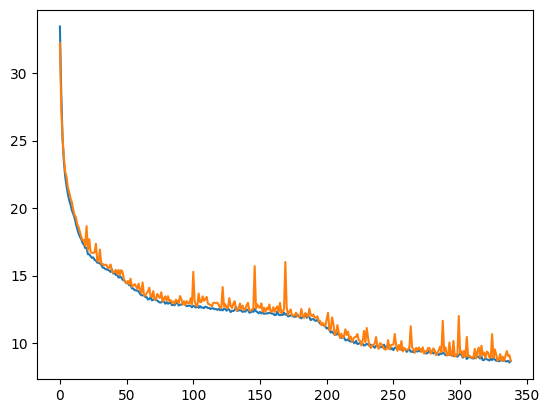

tensor(8.6117)
tensor(9.6963)
tensor(8.6957)
tensor(9.5640)
tensor(8.4930)
tensor(8.7282)
tensor(8.7158)
tensor(8.8187)
tensor(8.4752)
tensor(8.8180)
tensor(8.4345)
tensor(8.6723)
tensor(8.4593)
tensor(8.9484)
tensor(8.4867)
tensor(9.7068)
tensor(8.5825)
tensor(8.5832)
tensor(8.4743)
tensor(8.4527)
tensor(8.5918)
tensor(8.8225)
tensor(8.4973)
tensor(8.9805)
tensor(8.3938)
tensor(8.9172)
tensor(8.6468)
tensor(8.6345)
tensor(8.5472)
tensor(8.8892)
tensor(8.4108)
tensor(9.4206)
tensor(8.5579)
tensor(8.9517)
tensor(8.4813)
tensor(8.6421)
tensor(8.5870)
tensor(8.5056)
tensor(8.3474)
tensor(8.5159)


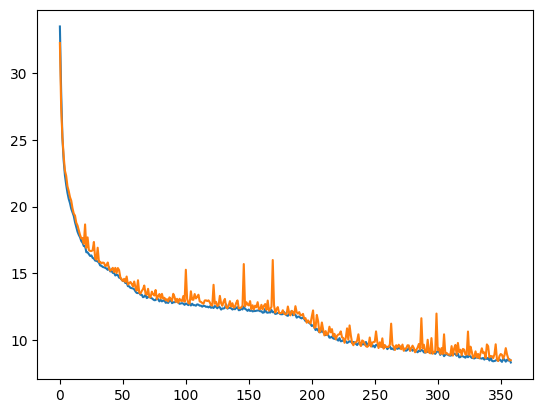

tensor(8.4251)
tensor(8.5117)
tensor(8.4050)
tensor(8.6202)
tensor(8.3562)
tensor(8.5793)
tensor(8.3897)
tensor(8.8426)
tensor(8.3662)
tensor(8.4337)
tensor(8.3332)
tensor(8.8321)
tensor(8.4377)
tensor(8.4136)
tensor(8.2852)
tensor(8.4625)
tensor(8.1982)
tensor(8.5926)
tensor(8.3953)
tensor(8.7508)
tensor(8.3261)
tensor(8.3338)
tensor(8.3391)
tensor(8.8216)
tensor(8.2500)
tensor(8.3488)
tensor(8.4462)
tensor(8.7936)
tensor(8.2403)
tensor(8.3622)
tensor(8.2095)
tensor(8.2423)
tensor(8.1690)
tensor(8.6064)
tensor(8.1978)
tensor(8.2658)
tensor(8.3265)
tensor(8.4194)
tensor(8.1472)
tensor(8.4376)


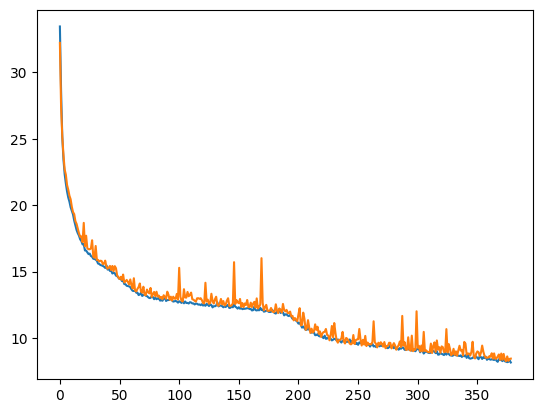

tensor(8.1181)
tensor(8.5363)
tensor(8.2243)
tensor(8.8841)
tensor(8.2833)
tensor(9.3057)
tensor(8.2444)
tensor(8.1981)
tensor(8.1401)
tensor(8.3638)
tensor(8.1441)
tensor(8.3064)
tensor(8.1592)
tensor(8.2633)
tensor(8.0779)
tensor(8.5327)
tensor(8.2753)
tensor(8.4444)
tensor(8.2796)
tensor(8.1058)
tensor(8.2296)
tensor(8.4619)
tensor(8.1153)
tensor(8.6698)
tensor(7.9851)
tensor(7.9711)
tensor(8.1556)
tensor(8.1886)
tensor(8.1171)
tensor(8.2827)
tensor(7.9781)
tensor(8.2867)
tensor(7.9964)
tensor(8.2525)
tensor(8.0368)
tensor(7.9833)
tensor(8.0904)
tensor(8.2993)
tensor(8.1580)
tensor(8.4325)


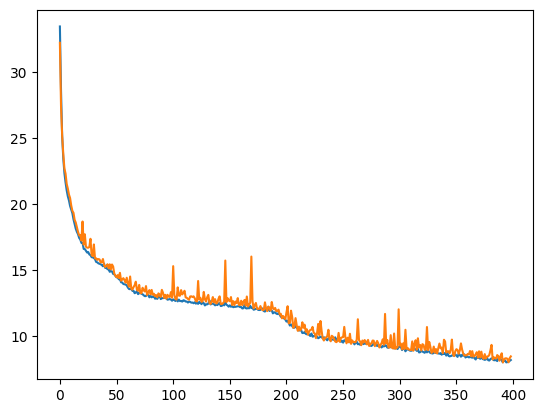

tensor(8.0822)
tensor(8.3849)
tensor(8.1382)
tensor(8.3789)
tensor(8.0194)
tensor(8.4098)
tensor(7.9702)
tensor(8.1622)
tensor(7.9735)
tensor(7.8996)
tensor(7.9431)
tensor(8.4243)
tensor(8.0898)
tensor(7.9625)
tensor(8.0806)
tensor(8.3272)
tensor(7.9274)
tensor(7.9436)
tensor(7.8609)
tensor(8.1923)
tensor(8.0191)
tensor(8.1971)
tensor(7.9392)
tensor(9.0752)
tensor(7.9617)
tensor(7.9238)
tensor(7.9824)
tensor(7.8192)
tensor(8.0203)
tensor(7.9095)
tensor(7.9978)
tensor(7.8754)
tensor(7.9583)
tensor(8.4414)
tensor(7.8791)
tensor(8.3659)
tensor(7.9572)
tensor(8.2676)
tensor(7.9292)
tensor(7.9035)


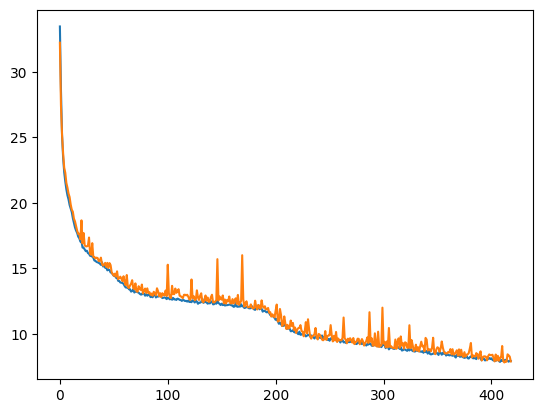

tensor(7.9632)
tensor(8.1300)
tensor(7.8060)
tensor(8.6817)
tensor(7.9445)
tensor(8.1736)
tensor(7.8145)
tensor(8.5901)
tensor(7.9850)
tensor(8.0611)
tensor(7.8112)
tensor(8.7205)
tensor(8.1910)
tensor(8.0500)
tensor(7.8462)
tensor(8.8529)
tensor(7.7928)
tensor(7.8044)
tensor(7.7778)
tensor(8.6188)
tensor(7.8446)
tensor(7.7542)
tensor(8.0992)
tensor(8.3512)
tensor(7.8267)
tensor(7.7769)
tensor(7.8767)
tensor(8.0378)
tensor(7.8129)
tensor(8.2054)
tensor(7.8869)
tensor(8.8924)
tensor(7.8564)
tensor(7.8212)
tensor(7.9250)
tensor(8.0384)
tensor(7.7489)
tensor(7.9812)
tensor(7.8255)
tensor(7.9228)


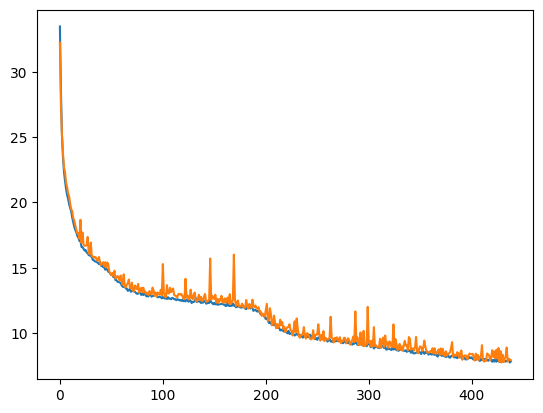

tensor(7.8222)
tensor(7.9983)
tensor(7.7817)
tensor(9.5469)
tensor(7.8811)
tensor(7.9392)
tensor(7.7830)
tensor(8.2561)
tensor(7.7595)
tensor(8.0137)
tensor(7.7099)
tensor(7.7956)
tensor(7.7036)
tensor(7.7189)
tensor(7.7453)
tensor(7.7131)
tensor(7.8049)
tensor(8.3838)
tensor(7.8357)
tensor(8.4635)
tensor(7.8704)
tensor(7.6787)
tensor(8.0024)
tensor(7.9597)
tensor(7.6024)
tensor(8.1466)
tensor(7.7505)
tensor(9.3176)
tensor(7.7150)
tensor(8.6782)
tensor(7.7324)
tensor(8.1598)
tensor(7.8317)
tensor(8.1410)
tensor(7.9578)
tensor(8.4582)
tensor(7.6923)
tensor(7.7610)
tensor(7.7084)
tensor(7.9408)


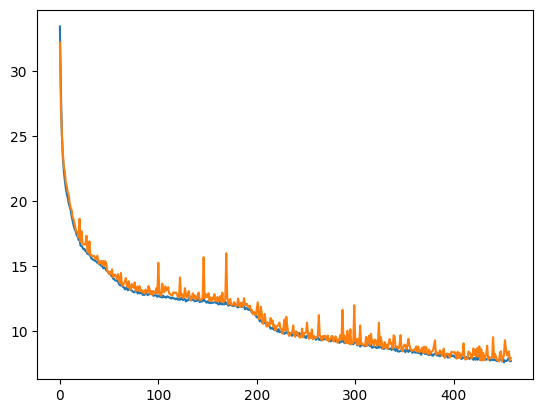

tensor(7.9319)
tensor(7.9737)
tensor(7.6841)
tensor(8.0395)
tensor(7.6782)
tensor(8.0466)
tensor(7.7237)
tensor(7.9587)
tensor(7.6870)
tensor(8.3053)
tensor(7.7878)
tensor(8.1998)
tensor(7.7237)
tensor(7.8766)
tensor(7.5860)
tensor(7.8474)
tensor(7.6063)
tensor(8.0577)
tensor(7.7157)
tensor(8.1285)
tensor(7.6553)
tensor(7.9122)
tensor(7.6771)
tensor(7.6850)
tensor(7.6267)
tensor(7.7070)
tensor(7.7520)
tensor(7.6780)
tensor(7.6258)
tensor(7.6464)
tensor(7.7589)
tensor(8.5088)
tensor(7.6233)
tensor(7.7201)
tensor(7.6855)
tensor(7.9010)
tensor(7.6224)
tensor(8.4029)
tensor(7.5453)
tensor(8.0019)


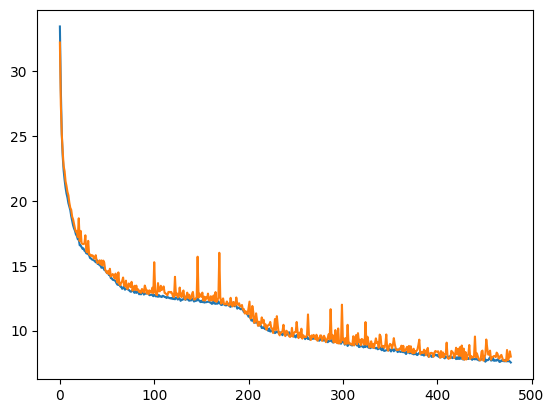

tensor(7.7710)
tensor(7.5581)
tensor(7.5829)
tensor(7.5788)
tensor(7.6818)
tensor(7.5539)
tensor(7.6325)
tensor(7.6546)
tensor(7.7584)
tensor(8.0381)
tensor(7.5804)
tensor(8.3387)
tensor(7.6743)
tensor(7.6177)
tensor(7.5254)
tensor(7.6986)
tensor(7.5237)
tensor(8.4553)
tensor(7.6743)
tensor(8.7410)
tensor(7.5860)
tensor(8.1195)
tensor(7.4512)
tensor(7.4935)
tensor(7.6594)
tensor(7.7437)
tensor(7.6668)
tensor(8.0047)
tensor(7.4741)
tensor(7.6371)
tensor(7.5848)
tensor(7.6848)
tensor(7.6603)
tensor(7.4304)
tensor(7.6922)
tensor(7.3751)
tensor(7.5828)
tensor(7.9133)
tensor(7.5169)
tensor(8.2580)


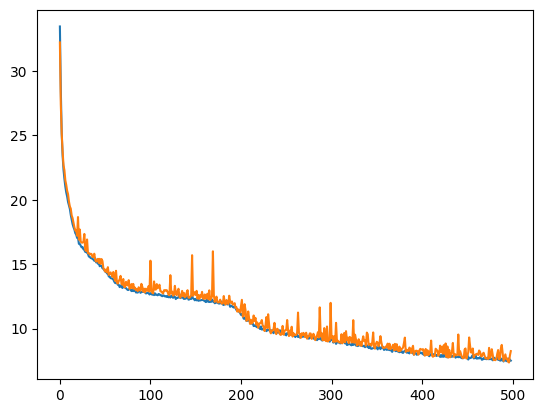

In [82]:
loss_log1 = []
loss_log_val1 = []
for epoch in range(500):
  tl = 0
  tl_val=0
  model1.train()
  for b in loaded_train1:
    l =  train1(b)
    tl += l
  model1.eval()
  for b in loaded_val1:
    l = test1(b)
    tl_val += l
  print(tl/len(loaded_train1))
  print(tl_val/len(loaded_val1))
  loss_log1.append(tl/len(loaded_train1))
  loss_log_val1.append(tl_val/len(loaded_val1))
  if epoch%20==19:
    plt.plot(loss_log1[1:])
    plt.plot(loss_log_val1[1:])
    plt.show()

In [83]:
y1s = [s.y1 for s in data_list]

In [85]:
print(max(y1s))
print(min(y1s))
print(np.mean(y1s))
print(np.std(y1s))
print(np.median(y1s))

tensor(119.4200)
tensor(6.3100)
66.74495
8.167941
67.28


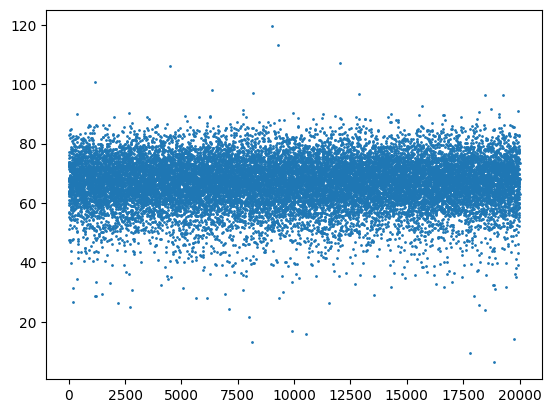

In [84]:
plt.scatter(np.arange(len(data_list)), y1s, s=1)

In [94]:
right = 0
wrong = 0
ok =0
errors1 = []
std = np.std(y1s)
for s in data_test1:
  model1.eval()
  pred = model1(s.enc)
  #print(pred.detach().numpy(), s.y.numpy())
  error = np.abs(pred.detach().numpy()-s.y1.numpy())
  errors1.append(error)

  if error <std/5:
    right+=1
  elif error<std/2:
    ok+=1
  else:
    wrong+=1
print(right, ok, wrong)

1286 915 299


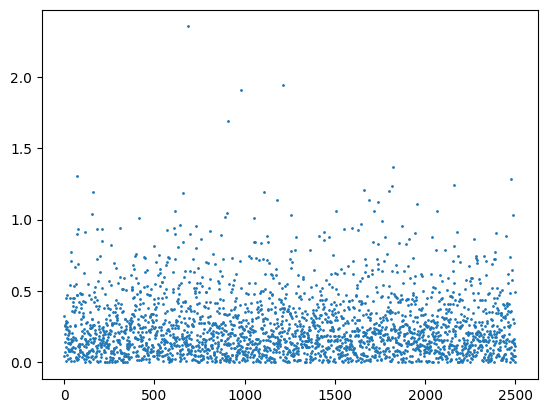

In [92]:
plt.scatter(np.arange(len(errors1)),errors1/std, s=1)

In [99]:
random.shuffle(data_list)

In [102]:
data_train2 = data_list[:15000]
data_val2 = data_list[15000:17500]
data_test2 = data_list[17500:]
loaded_train2 = DataLoader(data_train2, batch_size=50, shuffle=True)
loaded_val2 = DataLoader(data_val2, batch_size=50, shuffle=True)
loaded_test2 = DataLoader(data_test2, batch_size=50, shuffle=True)
model2 = predictor()
#optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
print(model2)


predictor(
  (regression): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [103]:
def train2(b):
  p = model2(b.enc)
  #print(np.shape(p))
  #print(b.enc)
  #print(p)
  l = loss_fn(p, b.y2.reshape((50,1)))
  #print(b.y1.reshape((50,1)))
  #print(pred)
  optimizer.zero_grad()
  l.backward()
  optimizer.step()
  return l.detach()
def test2(b):
  p = model2(b.enc)
  l = loss_fn(p, b.y2.reshape((50,1)))
  return l.detach()

tensor(4.8996)
tensor(0.7162)
tensor(0.6942)
tensor(0.6484)
tensor(0.6072)
tensor(0.5357)
tensor(0.4732)
tensor(0.3772)
tensor(0.3048)
tensor(0.2143)
tensor(0.2113)
tensor(0.1858)
tensor(0.1878)
tensor(0.1584)
tensor(0.1747)
tensor(0.1624)
tensor(0.1710)
tensor(0.1625)
tensor(0.1659)
tensor(0.1873)


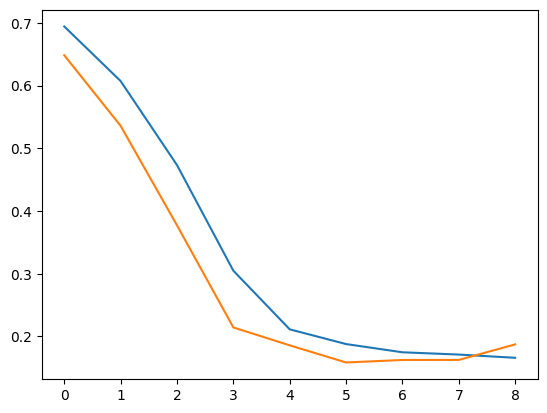

tensor(0.1638)
tensor(0.1505)
tensor(0.1661)
tensor(0.1731)
tensor(0.1611)
tensor(0.1444)
tensor(0.1649)
tensor(0.1493)
tensor(0.1600)
tensor(0.1457)
tensor(0.1606)
tensor(0.1468)
tensor(0.1609)
tensor(0.1433)
tensor(0.1564)
tensor(0.1484)
tensor(0.1605)
tensor(0.1400)
tensor(0.1617)
tensor(0.1520)


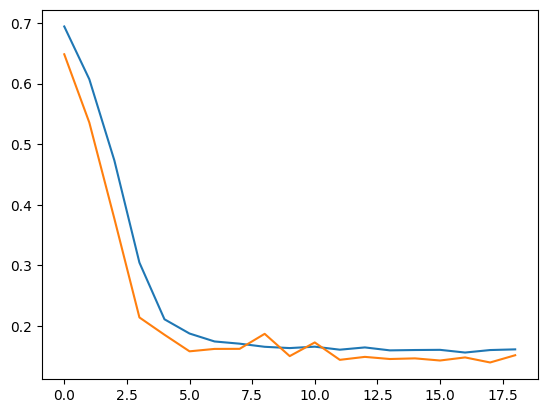

tensor(0.1565)
tensor(0.1593)
tensor(0.1563)
tensor(0.1500)
tensor(0.1565)
tensor(0.1382)
tensor(0.1611)
tensor(0.1428)
tensor(0.1549)
tensor(0.1418)
tensor(0.1607)
tensor(0.1394)
tensor(0.1552)
tensor(0.1438)
tensor(0.1512)
tensor(0.1388)
tensor(0.1551)
tensor(0.1419)
tensor(0.1514)
tensor(0.1401)


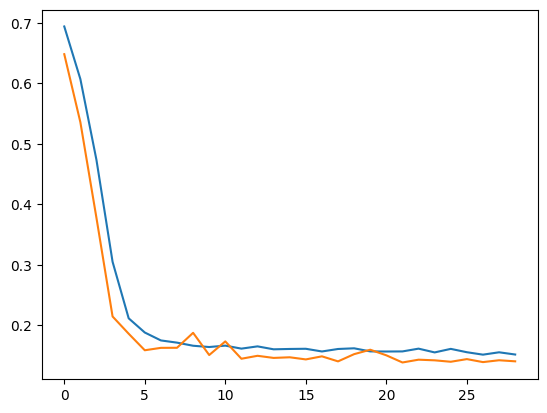

tensor(0.1566)
tensor(0.1370)
tensor(0.1497)
tensor(0.1383)
tensor(0.1520)
tensor(0.1527)
tensor(0.1553)
tensor(0.1557)
tensor(0.1513)
tensor(0.1385)
tensor(0.1512)
tensor(0.1777)
tensor(0.1486)
tensor(0.1473)
tensor(0.1502)
tensor(0.1541)
tensor(0.1514)
tensor(0.1677)
tensor(0.1510)
tensor(0.1392)


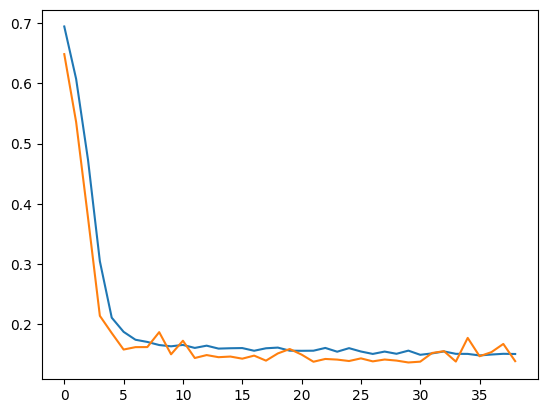

tensor(0.1512)
tensor(0.1714)
tensor(0.1528)
tensor(0.1423)
tensor(0.1541)
tensor(0.1466)
tensor(0.1495)
tensor(0.1833)
tensor(0.1491)
tensor(0.1497)
tensor(0.1479)
tensor(0.1365)
tensor(0.1472)
tensor(0.1411)
tensor(0.1473)
tensor(0.1359)
tensor(0.1474)
tensor(0.1649)
tensor(0.1501)
tensor(0.1341)


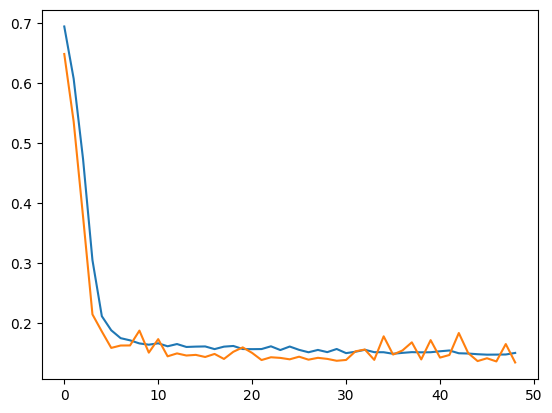

tensor(0.1509)
tensor(0.1355)
tensor(0.1461)
tensor(0.1533)
tensor(0.1483)
tensor(0.1361)
tensor(0.1458)
tensor(0.1376)
tensor(0.1483)
tensor(0.1417)
tensor(0.1466)
tensor(0.1507)
tensor(0.1452)
tensor(0.1449)
tensor(0.1525)
tensor(0.1338)
tensor(0.1445)
tensor(0.1330)
tensor(0.1432)
tensor(0.1422)


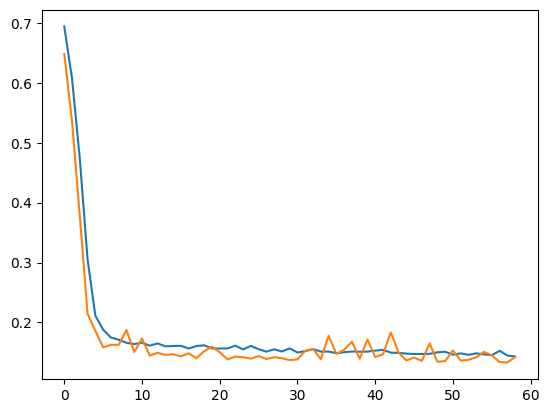

tensor(0.1469)
tensor(0.1477)
tensor(0.1430)
tensor(0.1453)
tensor(0.1501)
tensor(0.1581)
tensor(0.1483)
tensor(0.1549)
tensor(0.1439)
tensor(0.1375)
tensor(0.1415)
tensor(0.1307)
tensor(0.1425)
tensor(0.1635)
tensor(0.1436)
tensor(0.1365)
tensor(0.1427)
tensor(0.1323)
tensor(0.1451)
tensor(0.1304)


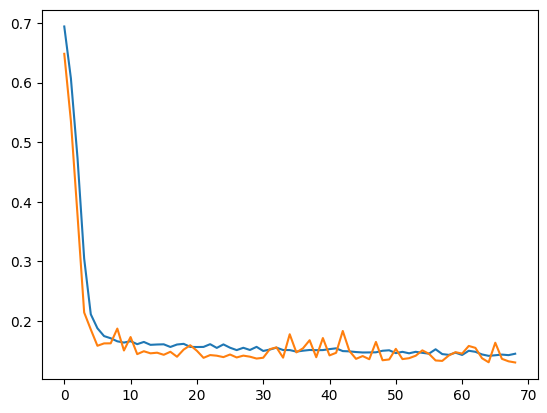

tensor(0.1425)
tensor(0.1594)
tensor(0.1479)
tensor(0.1346)
tensor(0.1409)
tensor(0.1357)
tensor(0.1404)
tensor(0.1466)
tensor(0.1414)
tensor(0.1315)
tensor(0.1374)
tensor(0.1322)
tensor(0.1401)
tensor(0.1285)
tensor(0.1392)
tensor(0.1282)
tensor(0.1399)
tensor(0.1273)
tensor(0.1367)
tensor(0.1312)


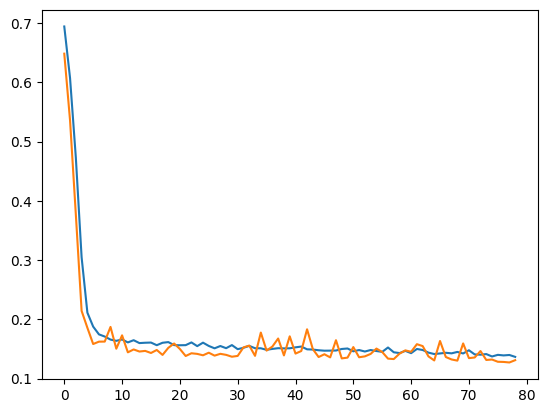

tensor(0.1394)
tensor(0.1333)
tensor(0.1397)
tensor(0.1354)
tensor(0.1412)
tensor(0.1254)
tensor(0.1396)
tensor(0.1391)
tensor(0.1408)
tensor(0.1247)
tensor(0.1355)
tensor(0.1236)
tensor(0.1344)
tensor(0.1275)
tensor(0.1348)
tensor(0.1226)
tensor(0.1337)
tensor(0.1344)
tensor(0.1378)
tensor(0.1232)


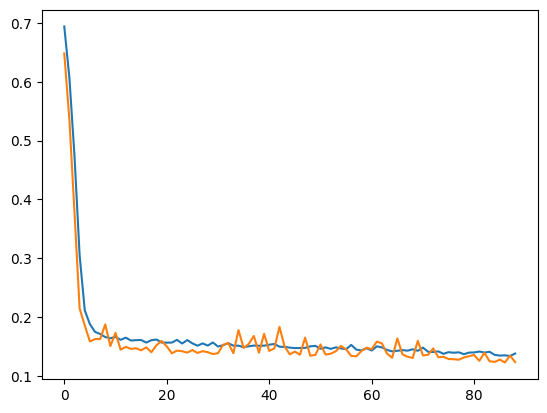

tensor(0.1365)
tensor(0.1300)
tensor(0.1309)
tensor(0.1391)
tensor(0.1318)
tensor(0.1224)
tensor(0.1331)
tensor(0.1194)
tensor(0.1326)
tensor(0.1191)
tensor(0.1342)
tensor(0.1217)
tensor(0.1258)
tensor(0.1239)
tensor(0.1309)
tensor(0.1260)
tensor(0.1279)
tensor(0.1228)
tensor(0.1275)
tensor(0.1252)


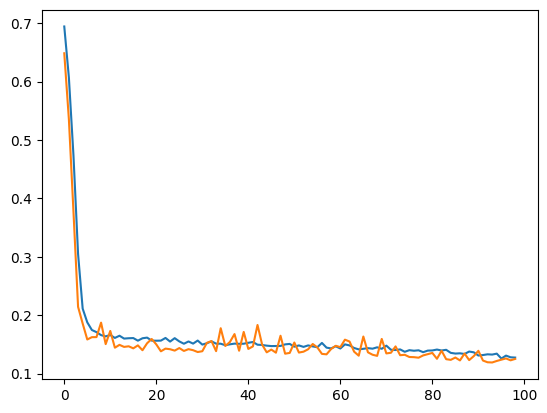

tensor(0.1292)
tensor(0.1475)
tensor(0.1288)
tensor(0.1297)
tensor(0.1259)
tensor(0.1230)
tensor(0.1253)
tensor(0.1185)
tensor(0.1272)
tensor(0.1180)
tensor(0.1256)
tensor(0.1241)
tensor(0.1273)
tensor(0.1169)
tensor(0.1288)
tensor(0.1216)
tensor(0.1275)
tensor(0.1165)
tensor(0.1259)
tensor(0.1219)


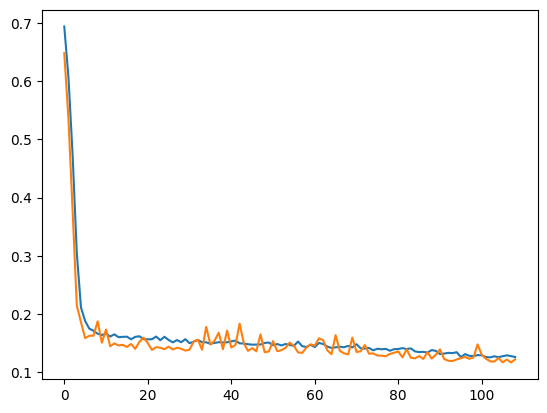

tensor(0.1302)
tensor(0.1234)
tensor(0.1263)
tensor(0.1205)
tensor(0.1234)
tensor(0.1288)
tensor(0.1288)
tensor(0.1446)
tensor(0.1244)
tensor(0.1184)
tensor(0.1263)
tensor(0.1173)
tensor(0.1261)
tensor(0.1134)
tensor(0.1270)
tensor(0.1195)
tensor(0.1277)
tensor(0.1154)
tensor(0.1238)
tensor(0.1136)


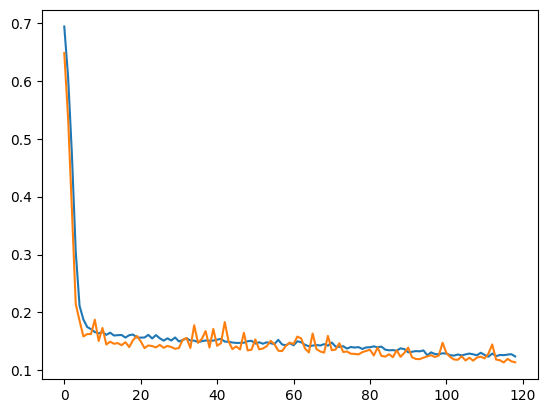

tensor(0.1235)
tensor(0.1145)
tensor(0.1241)
tensor(0.1132)
tensor(0.1264)
tensor(0.1191)
tensor(0.1276)
tensor(0.1252)
tensor(0.1235)
tensor(0.1271)
tensor(0.1252)
tensor(0.1248)
tensor(0.1235)
tensor(0.1197)
tensor(0.1230)
tensor(0.1131)
tensor(0.1233)
tensor(0.1162)
tensor(0.1231)
tensor(0.1361)


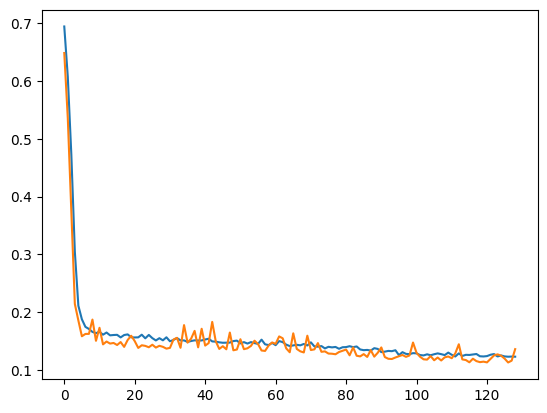

tensor(0.1234)
tensor(0.1182)
tensor(0.1217)
tensor(0.1153)
tensor(0.1209)
tensor(0.1262)
tensor(0.1216)
tensor(0.1154)
tensor(0.1252)
tensor(0.1267)
tensor(0.1222)
tensor(0.1204)
tensor(0.1230)
tensor(0.1135)
tensor(0.1213)
tensor(0.1230)
tensor(0.1226)
tensor(0.1117)
tensor(0.1213)
tensor(0.1232)


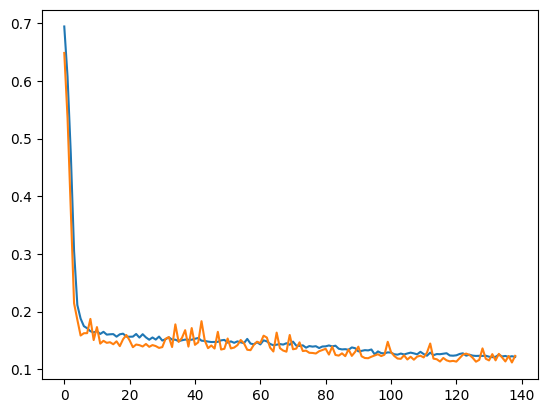

tensor(0.1226)
tensor(0.1179)
tensor(0.1238)
tensor(0.1326)
tensor(0.1227)
tensor(0.1114)
tensor(0.1195)
tensor(0.1126)
tensor(0.1191)
tensor(0.1215)
tensor(0.1201)
tensor(0.1170)
tensor(0.1193)
tensor(0.1174)
tensor(0.1207)
tensor(0.1178)
tensor(0.1215)
tensor(0.1155)
tensor(0.1205)
tensor(0.1203)


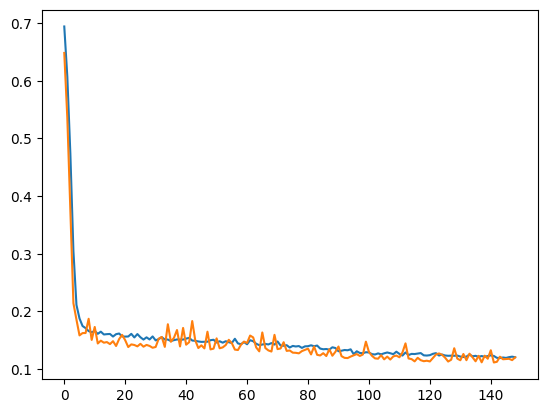

tensor(0.1179)
tensor(0.1222)
tensor(0.1191)
tensor(0.1097)
tensor(0.1179)
tensor(0.1100)
tensor(0.1185)
tensor(0.1135)
tensor(0.1215)
tensor(0.1204)
tensor(0.1195)
tensor(0.1339)
tensor(0.1183)
tensor(0.1117)
tensor(0.1213)
tensor(0.1227)
tensor(0.1202)
tensor(0.1074)
tensor(0.1166)
tensor(0.1101)


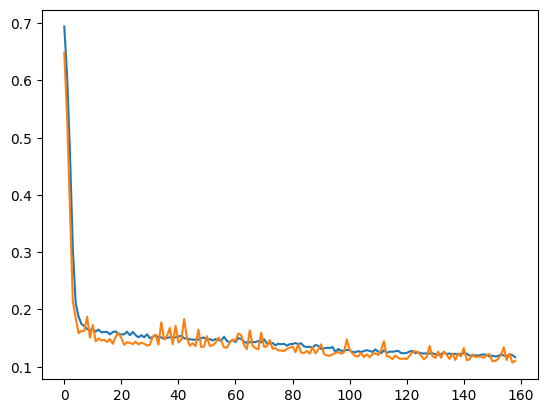

tensor(0.1184)
tensor(0.1376)
tensor(0.1182)
tensor(0.1152)
tensor(0.1186)
tensor(0.1129)
tensor(0.1171)
tensor(0.1076)
tensor(0.1169)
tensor(0.1124)
tensor(0.1178)
tensor(0.1231)
tensor(0.1169)
tensor(0.1105)
tensor(0.1168)
tensor(0.1152)
tensor(0.1174)
tensor(0.1072)
tensor(0.1179)
tensor(0.1196)


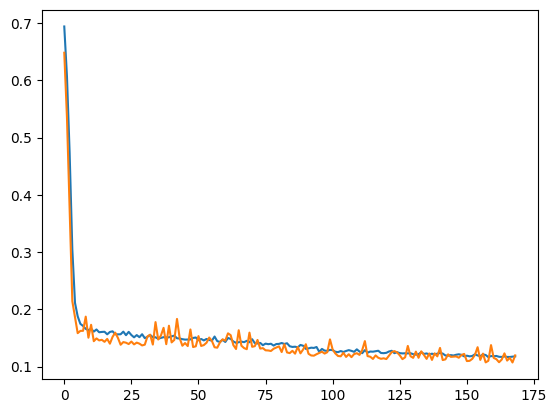

tensor(0.1156)
tensor(0.1335)
tensor(0.1171)
tensor(0.1194)
tensor(0.1169)
tensor(0.1068)
tensor(0.1152)
tensor(0.1121)
tensor(0.1160)
tensor(0.1235)
tensor(0.1191)
tensor(0.1355)
tensor(0.1163)
tensor(0.1132)
tensor(0.1162)
tensor(0.1276)
tensor(0.1160)
tensor(0.1206)
tensor(0.1148)
tensor(0.1108)


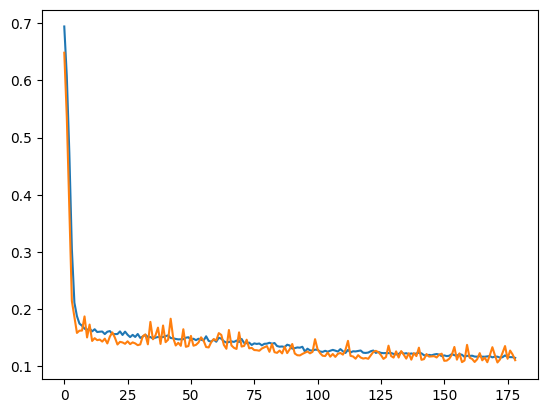

tensor(0.1130)
tensor(0.1073)
tensor(0.1150)
tensor(0.1066)
tensor(0.1143)
tensor(0.1088)
tensor(0.1147)
tensor(0.1233)
tensor(0.1167)
tensor(0.1437)
tensor(0.1154)
tensor(0.1076)
tensor(0.1159)
tensor(0.1079)
tensor(0.1137)
tensor(0.1138)
tensor(0.1157)
tensor(0.1784)
tensor(0.1173)
tensor(0.1082)


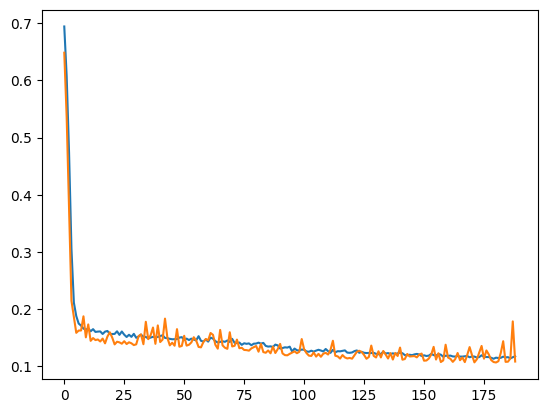

tensor(0.1153)
tensor(0.1078)
tensor(0.1151)
tensor(0.1090)
tensor(0.1140)
tensor(0.1064)
tensor(0.1149)
tensor(0.1066)
tensor(0.1124)
tensor(0.1084)
tensor(0.1140)
tensor(0.1099)
tensor(0.1128)
tensor(0.1106)
tensor(0.1128)
tensor(0.1135)
tensor(0.1129)
tensor(0.1056)
tensor(0.1153)
tensor(0.1119)


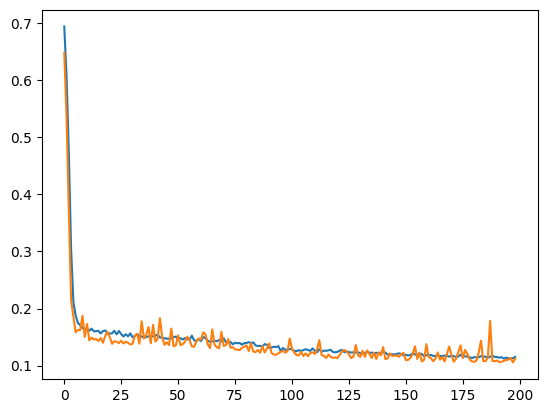

tensor(0.1135)
tensor(0.1108)
tensor(0.1124)
tensor(0.1156)
tensor(0.1143)
tensor(0.1161)
tensor(0.1165)
tensor(0.1208)
tensor(0.1130)
tensor(0.1063)
tensor(0.1129)
tensor(0.1057)
tensor(0.1128)
tensor(0.1082)
tensor(0.1135)
tensor(0.1069)
tensor(0.1136)
tensor(0.1078)
tensor(0.1137)
tensor(0.1105)


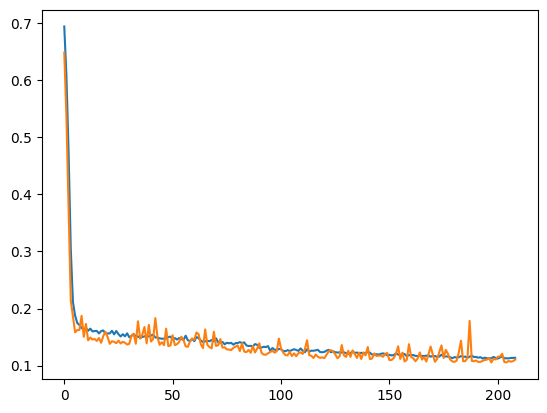

tensor(0.1157)
tensor(0.1089)
tensor(0.1113)
tensor(0.1069)
tensor(0.1128)
tensor(0.1116)
tensor(0.1132)
tensor(0.1234)
tensor(0.1127)
tensor(0.1158)
tensor(0.1122)
tensor(0.1151)
tensor(0.1146)
tensor(0.1066)
tensor(0.1114)
tensor(0.1056)
tensor(0.1122)
tensor(0.1077)
tensor(0.1116)
tensor(0.1115)


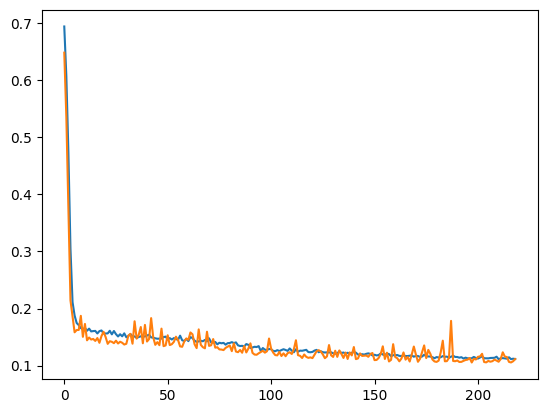

tensor(0.1125)
tensor(0.1061)
tensor(0.1111)
tensor(0.1203)
tensor(0.1127)
tensor(0.1085)
tensor(0.1120)
tensor(0.1100)
tensor(0.1109)
tensor(0.1048)
tensor(0.1111)
tensor(0.1037)
tensor(0.1102)
tensor(0.1068)
tensor(0.1083)
tensor(0.1058)
tensor(0.1109)
tensor(0.1112)
tensor(0.1087)
tensor(0.1062)


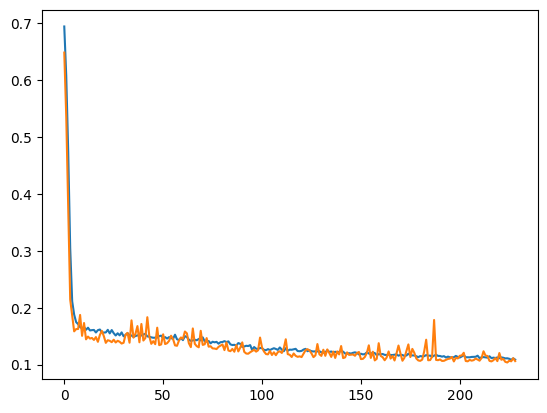

tensor(0.1104)
tensor(0.1164)
tensor(0.1086)
tensor(0.1008)
tensor(0.1111)
tensor(0.1076)
tensor(0.1102)
tensor(0.1193)
tensor(0.1083)
tensor(0.1091)
tensor(0.1104)
tensor(0.1035)
tensor(0.1115)
tensor(0.1047)
tensor(0.1083)
tensor(0.1048)
tensor(0.1088)
tensor(0.1079)
tensor(0.1108)
tensor(0.1069)


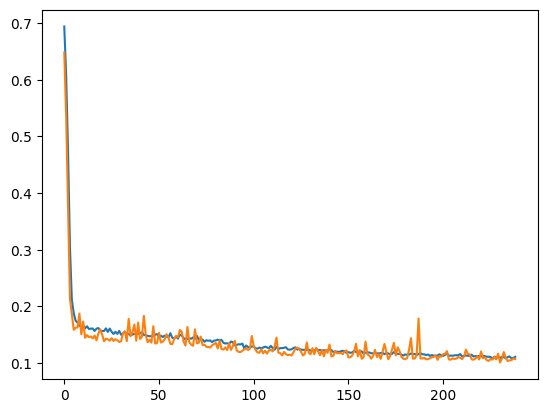

tensor(0.1091)
tensor(0.1010)
tensor(0.1086)
tensor(0.1135)
tensor(0.1103)
tensor(0.1026)
tensor(0.1082)
tensor(0.1045)
tensor(0.1099)
tensor(0.1139)
tensor(0.1102)
tensor(0.1069)
tensor(0.1090)
tensor(0.1035)
tensor(0.1084)
tensor(0.1005)
tensor(0.1085)
tensor(0.1031)
tensor(0.1074)
tensor(0.1010)


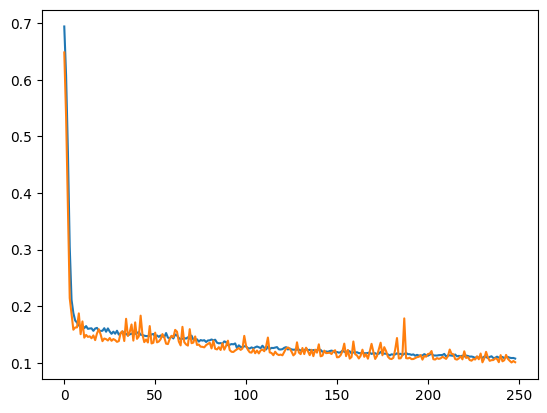

tensor(0.1095)
tensor(0.1063)
tensor(0.1085)
tensor(0.1138)
tensor(0.1092)
tensor(0.1077)
tensor(0.1075)
tensor(0.1056)
tensor(0.1067)
tensor(0.1008)
tensor(0.1081)
tensor(0.1256)
tensor(0.1094)
tensor(0.1037)
tensor(0.1066)
tensor(0.1124)
tensor(0.1078)
tensor(0.1014)
tensor(0.1099)
tensor(0.1048)


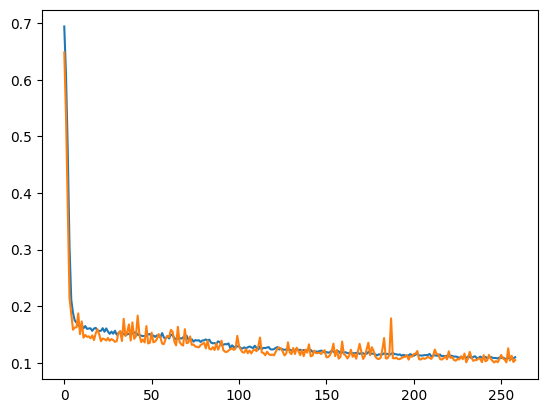

tensor(0.1076)
tensor(0.1010)
tensor(0.1064)
tensor(0.1059)
tensor(0.1083)
tensor(0.1130)
tensor(0.1073)
tensor(0.1012)
tensor(0.1080)
tensor(0.1056)
tensor(0.1081)
tensor(0.1017)
tensor(0.1072)
tensor(0.1072)
tensor(0.1084)
tensor(0.1034)
tensor(0.1090)
tensor(0.1033)
tensor(0.1081)
tensor(0.1333)


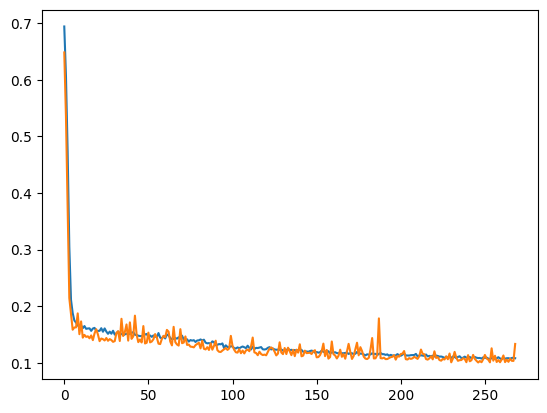

tensor(0.1069)
tensor(0.1208)
tensor(0.1066)
tensor(0.1088)
tensor(0.1079)
tensor(0.1082)
tensor(0.1081)
tensor(0.1107)
tensor(0.1079)
tensor(0.1023)
tensor(0.1096)
tensor(0.1127)
tensor(0.1074)
tensor(0.1034)
tensor(0.1068)
tensor(0.1075)
tensor(0.1102)
tensor(0.1033)
tensor(0.1065)
tensor(0.1017)


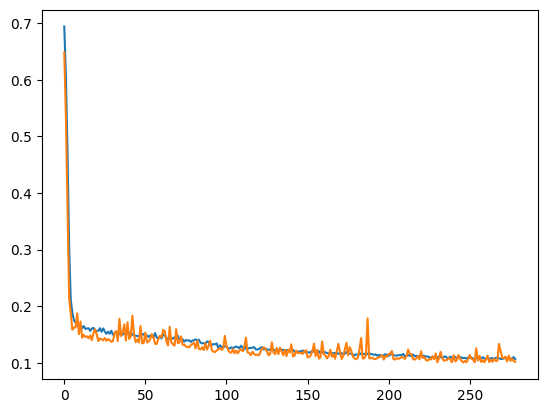

tensor(0.1079)
tensor(0.1217)
tensor(0.1070)
tensor(0.1103)
tensor(0.1103)
tensor(0.1062)
tensor(0.1065)
tensor(0.1021)
tensor(0.1066)
tensor(0.1037)
tensor(0.1089)
tensor(0.1109)
tensor(0.1057)
tensor(0.0999)
tensor(0.1077)
tensor(0.1011)
tensor(0.1058)
tensor(0.1038)
tensor(0.1070)
tensor(0.1077)


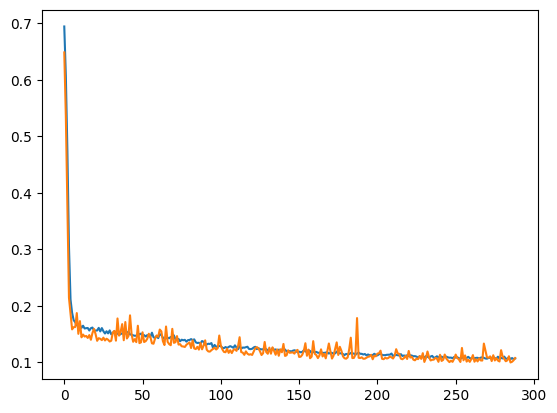

tensor(0.1069)
tensor(0.1157)
tensor(0.1065)
tensor(0.1102)
tensor(0.1073)
tensor(0.1028)
tensor(0.1072)
tensor(0.1010)
tensor(0.1065)
tensor(0.1103)
tensor(0.1068)
tensor(0.1098)
tensor(0.1059)
tensor(0.1007)
tensor(0.1061)
tensor(0.1014)
tensor(0.1059)
tensor(0.1002)
tensor(0.1071)
tensor(0.1060)


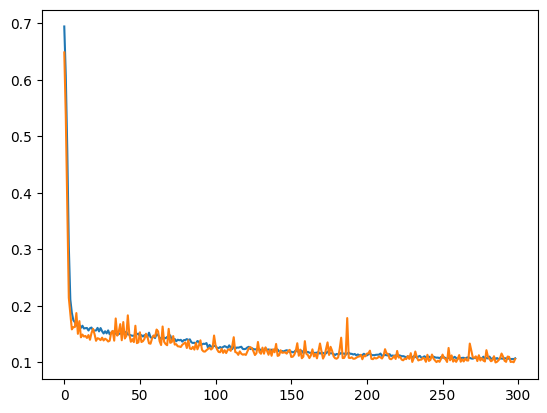

tensor(0.1063)
tensor(0.1048)
tensor(0.1057)
tensor(0.1117)
tensor(0.1071)
tensor(0.1021)
tensor(0.1060)
tensor(0.1029)
tensor(0.1107)
tensor(0.1033)
tensor(0.1052)
tensor(0.0994)
tensor(0.1064)
tensor(0.1028)
tensor(0.1063)
tensor(0.0985)
tensor(0.1070)
tensor(0.1014)
tensor(0.1058)
tensor(0.1114)


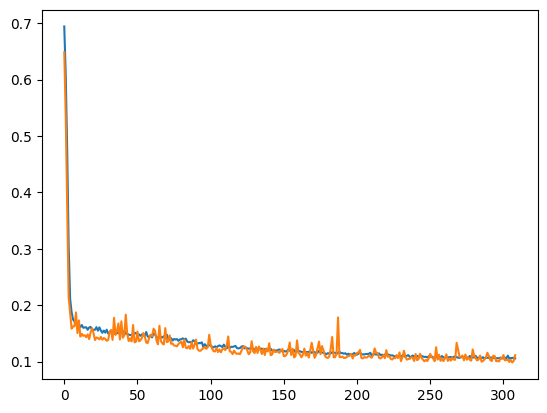

tensor(0.1077)
tensor(0.0999)
tensor(0.1078)
tensor(0.1108)
tensor(0.1064)
tensor(0.1013)
tensor(0.1060)
tensor(0.1058)
tensor(0.1055)
tensor(0.1098)
tensor(0.1057)
tensor(0.1005)
tensor(0.1064)
tensor(0.1012)
tensor(0.1071)
tensor(0.1049)
tensor(0.1047)
tensor(0.1023)
tensor(0.1049)
tensor(0.1146)


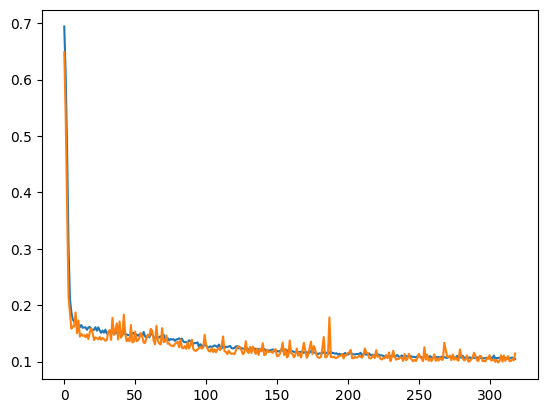

tensor(0.1087)
tensor(0.1127)
tensor(0.1039)
tensor(0.1081)
tensor(0.1052)
tensor(0.1061)
tensor(0.1056)
tensor(0.1068)
tensor(0.1055)
tensor(0.1030)
tensor(0.1074)
tensor(0.1087)
tensor(0.1055)
tensor(0.1043)
tensor(0.1058)
tensor(0.1025)
tensor(0.1043)
tensor(0.1327)
tensor(0.1074)
tensor(0.1067)


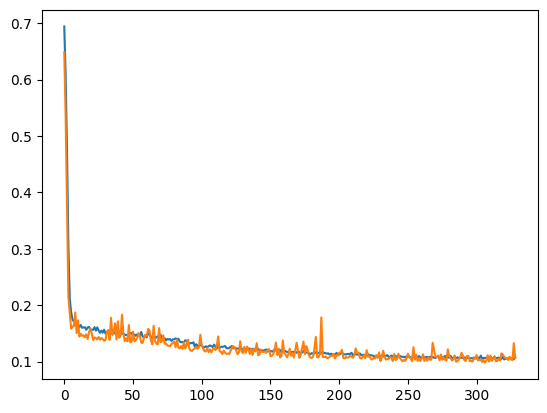

tensor(0.1047)
tensor(0.0991)
tensor(0.1062)
tensor(0.0983)
tensor(0.1054)
tensor(0.1029)
tensor(0.1050)
tensor(0.1112)
tensor(0.1062)
tensor(0.1066)
tensor(0.1048)
tensor(0.1034)
tensor(0.1056)
tensor(0.0992)
tensor(0.1066)
tensor(0.1006)
tensor(0.1057)
tensor(0.1252)
tensor(0.1066)
tensor(0.1049)


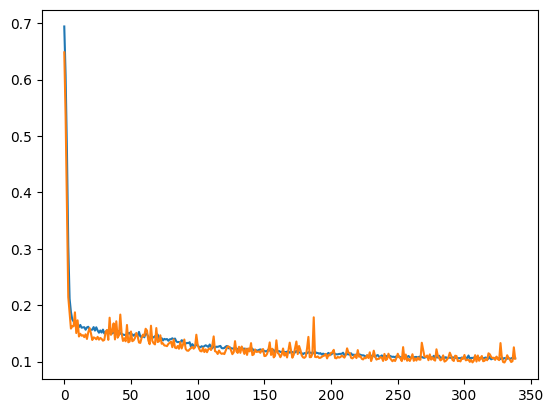

tensor(0.1049)
tensor(0.1146)
tensor(0.1061)
tensor(0.1017)
tensor(0.1044)
tensor(0.1070)
tensor(0.1067)
tensor(0.1029)
tensor(0.1057)
tensor(0.1031)
tensor(0.1046)
tensor(0.1034)
tensor(0.1045)
tensor(0.0995)
tensor(0.1062)
tensor(0.1096)
tensor(0.1053)
tensor(0.1080)
tensor(0.1067)
tensor(0.1012)


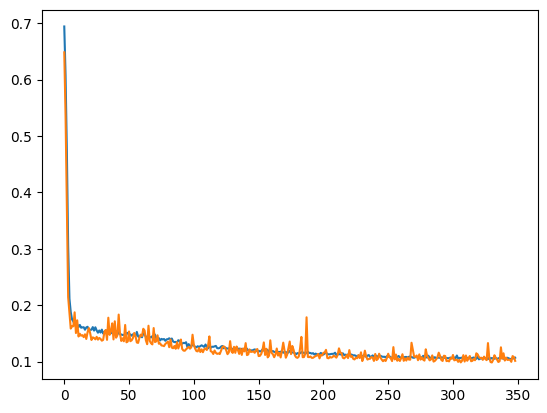

tensor(0.1051)
tensor(0.0983)
tensor(0.1035)
tensor(0.1030)
tensor(0.1063)
tensor(0.0990)
tensor(0.1046)
tensor(0.0997)
tensor(0.1042)
tensor(0.1011)
tensor(0.1043)
tensor(0.1073)
tensor(0.1051)
tensor(0.0970)
tensor(0.1052)
tensor(0.1013)
tensor(0.1047)
tensor(0.1097)
tensor(0.1041)
tensor(0.0983)


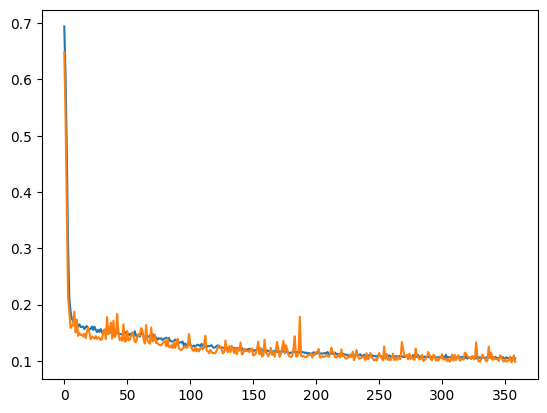

tensor(0.1038)
tensor(0.0994)
tensor(0.1031)
tensor(0.0994)
tensor(0.1047)
tensor(0.0999)
tensor(0.1038)
tensor(0.1029)
tensor(0.1035)
tensor(0.0984)
tensor(0.1033)
tensor(0.1040)
tensor(0.1047)
tensor(0.1049)
tensor(0.1029)
tensor(0.0963)
tensor(0.1044)
tensor(0.1103)
tensor(0.1051)
tensor(0.1025)


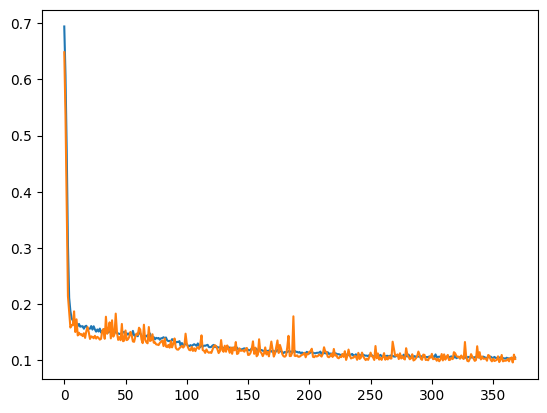

tensor(0.1043)
tensor(0.1016)
tensor(0.1022)
tensor(0.1079)
tensor(0.1028)
tensor(0.1003)
tensor(0.1044)
tensor(0.0996)
tensor(0.1047)
tensor(0.1366)
tensor(0.1054)
tensor(0.1055)
tensor(0.1037)
tensor(0.0986)
tensor(0.1036)
tensor(0.0960)
tensor(0.1033)
tensor(0.0987)
tensor(0.1047)
tensor(0.1106)


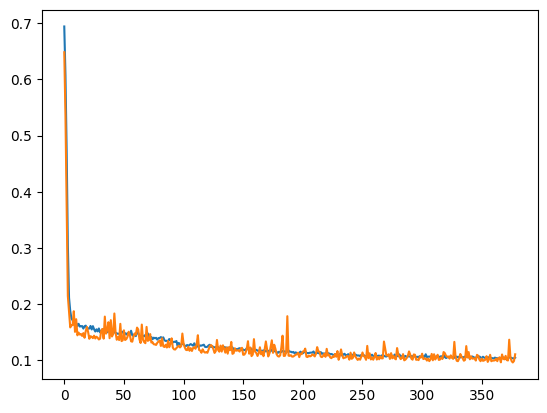

tensor(0.1028)
tensor(0.0991)
tensor(0.1038)
tensor(0.0984)
tensor(0.1040)
tensor(0.1093)
tensor(0.1046)
tensor(0.0965)
tensor(0.1039)
tensor(0.1266)
tensor(0.1022)
tensor(0.0997)
tensor(0.1042)
tensor(0.1012)
tensor(0.1035)
tensor(0.1310)
tensor(0.1031)
tensor(0.0976)
tensor(0.1024)
tensor(0.1020)


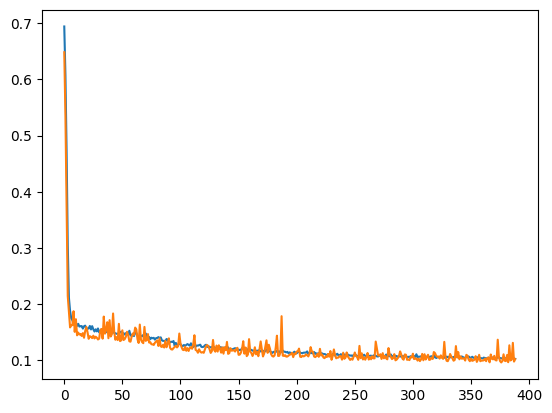

tensor(0.1046)
tensor(0.1022)
tensor(0.1043)
tensor(0.1002)
tensor(0.1021)
tensor(0.0991)
tensor(0.1043)
tensor(0.1038)
tensor(0.1043)
tensor(0.1053)
tensor(0.1024)
tensor(0.0973)
tensor(0.1021)
tensor(0.1006)
tensor(0.1024)
tensor(0.1064)
tensor(0.1022)
tensor(0.0996)
tensor(0.1029)
tensor(0.0995)


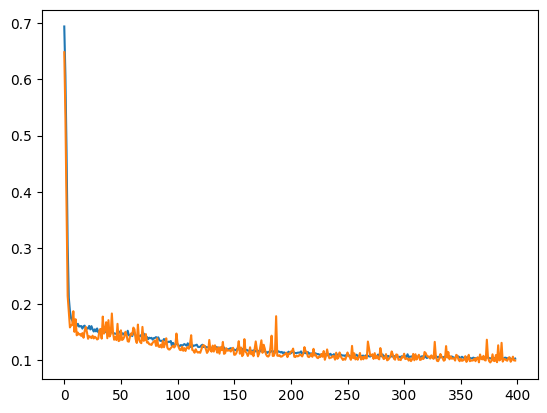

tensor(0.1029)
tensor(0.1051)
tensor(0.1042)
tensor(0.0991)
tensor(0.1050)
tensor(0.0985)
tensor(0.1034)
tensor(0.1008)
tensor(0.1028)
tensor(0.0970)
tensor(0.1035)
tensor(0.0981)
tensor(0.1032)
tensor(0.1005)
tensor(0.1014)
tensor(0.0984)
tensor(0.1031)
tensor(0.1045)
tensor(0.1010)
tensor(0.0973)


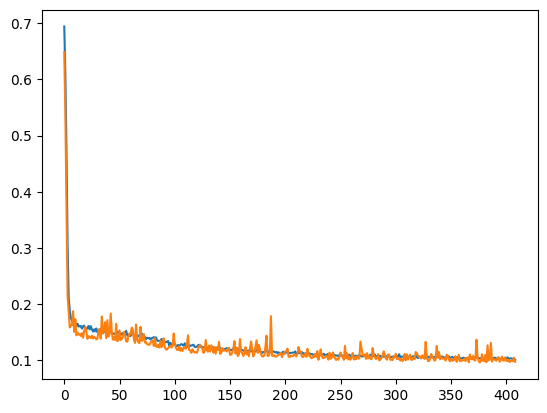

tensor(0.1034)
tensor(0.0992)
tensor(0.1023)
tensor(0.0978)
tensor(0.1025)
tensor(0.1046)
tensor(0.1006)
tensor(0.1045)
tensor(0.1027)
tensor(0.1000)
tensor(0.1036)
tensor(0.1047)
tensor(0.1021)
tensor(0.1018)
tensor(0.1011)
tensor(0.1015)
tensor(0.1031)
tensor(0.1048)
tensor(0.1022)
tensor(0.1071)


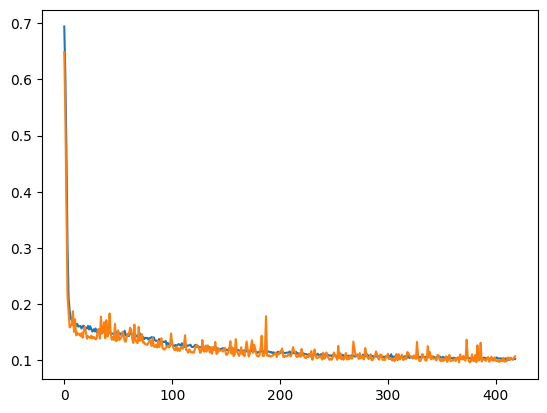

tensor(0.1013)
tensor(0.0973)
tensor(0.1038)
tensor(0.1025)
tensor(0.1026)
tensor(0.0987)
tensor(0.1026)
tensor(0.0980)
tensor(0.1048)
tensor(0.0989)
tensor(0.1024)
tensor(0.0981)
tensor(0.1008)
tensor(0.0977)
tensor(0.1010)
tensor(0.0964)
tensor(0.1010)
tensor(0.0956)
tensor(0.1042)
tensor(0.1001)


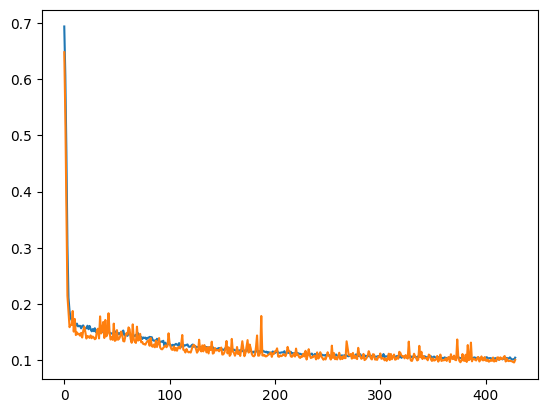

tensor(0.1014)
tensor(0.0969)
tensor(0.1018)
tensor(0.1028)
tensor(0.1029)
tensor(0.0998)
tensor(0.1010)
tensor(0.0990)
tensor(0.1023)
tensor(0.0995)
tensor(0.1020)
tensor(0.0950)
tensor(0.1011)
tensor(0.0970)
tensor(0.1012)
tensor(0.0961)
tensor(0.1030)
tensor(0.1017)
tensor(0.1026)
tensor(0.1104)


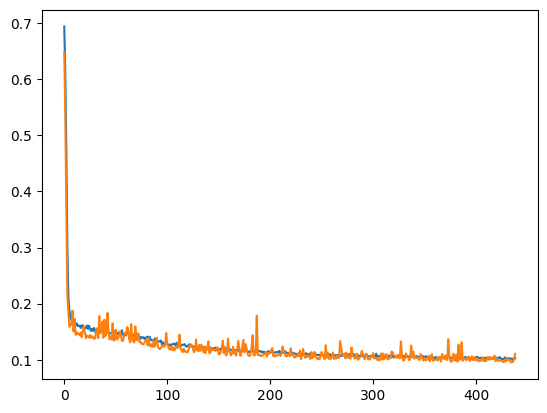

tensor(0.1029)
tensor(0.0970)
tensor(0.1020)
tensor(0.1096)
tensor(0.1023)
tensor(0.0983)
tensor(0.1024)
tensor(0.1004)
tensor(0.1014)
tensor(0.1078)
tensor(0.1017)
tensor(0.1090)
tensor(0.1015)
tensor(0.0962)
tensor(0.0993)
tensor(0.0966)
tensor(0.1023)
tensor(0.1015)
tensor(0.1017)
tensor(0.1011)


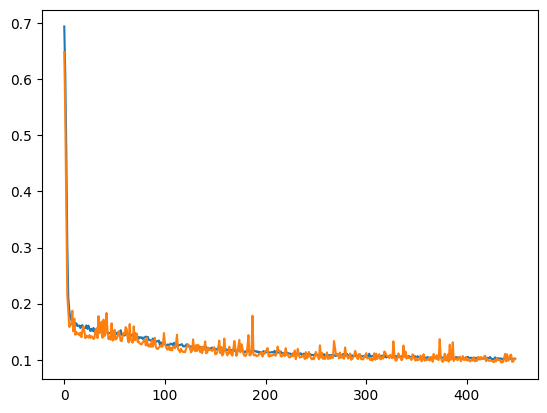

tensor(0.1006)
tensor(0.0988)
tensor(0.1028)
tensor(0.1004)
tensor(0.1005)
tensor(0.0992)
tensor(0.1018)
tensor(0.1042)
tensor(0.1010)
tensor(0.0971)
tensor(0.1011)
tensor(0.1039)
tensor(0.1010)
tensor(0.1086)
tensor(0.1012)
tensor(0.1027)
tensor(0.1034)
tensor(0.0969)
tensor(0.1010)
tensor(0.0987)


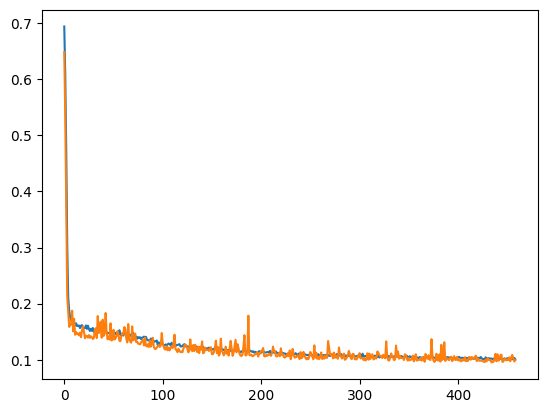

tensor(0.1003)
tensor(0.1005)
tensor(0.0999)
tensor(0.0975)
tensor(0.1007)
tensor(0.1024)
tensor(0.1016)
tensor(0.0990)
tensor(0.1011)
tensor(0.0977)
tensor(0.1017)
tensor(0.1069)
tensor(0.1011)
tensor(0.0970)
tensor(0.1023)
tensor(0.0947)
tensor(0.0999)
tensor(0.0971)
tensor(0.1004)
tensor(0.1068)


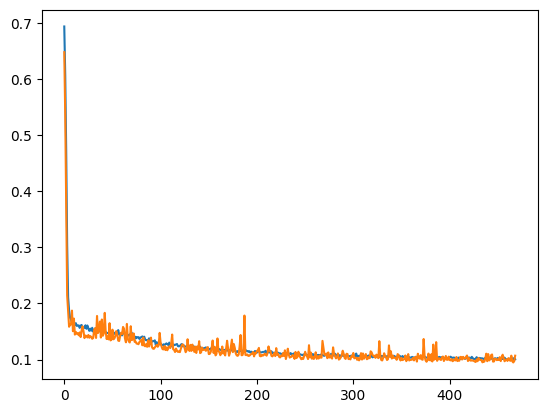

tensor(0.0997)
tensor(0.0984)
tensor(0.1010)
tensor(0.0987)
tensor(0.1016)
tensor(0.0940)
tensor(0.0994)
tensor(0.1042)
tensor(0.1006)
tensor(0.0967)
tensor(0.1004)
tensor(0.0983)
tensor(0.0999)
tensor(0.1023)
tensor(0.0988)
tensor(0.0963)
tensor(0.1010)
tensor(0.1009)
tensor(0.0985)
tensor(0.0979)


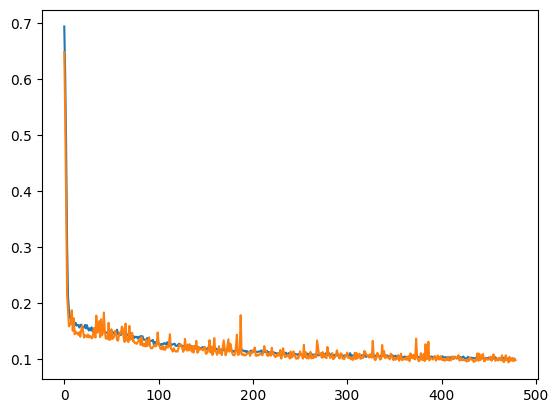

tensor(0.1011)
tensor(0.0959)
tensor(0.0999)
tensor(0.1012)
tensor(0.1012)
tensor(0.1007)
tensor(0.1014)
tensor(0.0963)
tensor(0.1036)
tensor(0.1049)
tensor(0.1009)
tensor(0.0973)
tensor(0.1022)
tensor(0.0970)
tensor(0.0998)
tensor(0.1034)
tensor(0.1010)
tensor(0.0961)
tensor(0.0994)
tensor(0.0978)


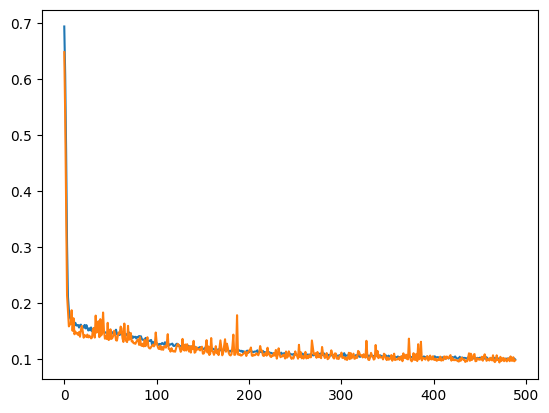

tensor(0.0990)
tensor(0.1091)
tensor(0.0995)
tensor(0.1064)
tensor(0.0996)
tensor(0.0951)
tensor(0.1000)
tensor(0.0946)
tensor(0.0997)
tensor(0.0957)
tensor(0.1005)
tensor(0.1032)
tensor(0.1006)
tensor(0.0972)
tensor(0.0990)
tensor(0.1000)
tensor(0.0998)
tensor(0.1014)
tensor(0.1007)
tensor(0.0952)


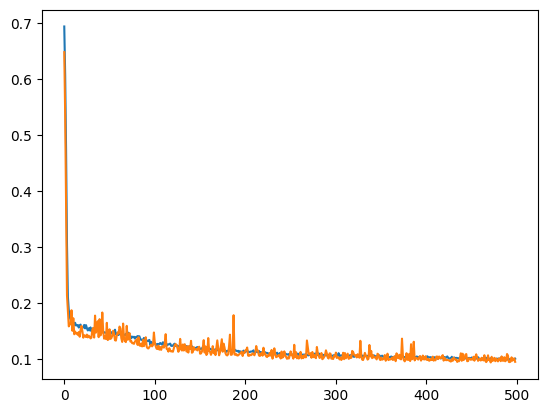

In [104]:
loss_log2 = []
loss_log_val2 = []
for epoch in range(500):
  tl = 0
  tl_val=0
  model2.train()
  for b in loaded_train2:
    l =  train2(b)
    tl += l
  model2.eval()
  for b in loaded_val2:
    l = test2(b)
    tl_val += l
  print(tl/len(loaded_train2))
  print(tl_val/len(loaded_val2))
  loss_log2.append(tl/len(loaded_train2))
  loss_log_val2.append(tl_val/len(loaded_val2))
  if epoch%10==9:
    plt.plot(loss_log2[1:])
    plt.plot(loss_log_val2[1:])
    plt.show()

In [106]:
y2s = [s.y2 for s in data_list]
print(max(y2s))
print(min(y2s))
print(np.mean(y2s))
print(np.std(y2s))
print(np.median(y2s))

tensor(-3.9729)
tensor(-11.6628)
-6.6354795
0.6096486
-6.6395783


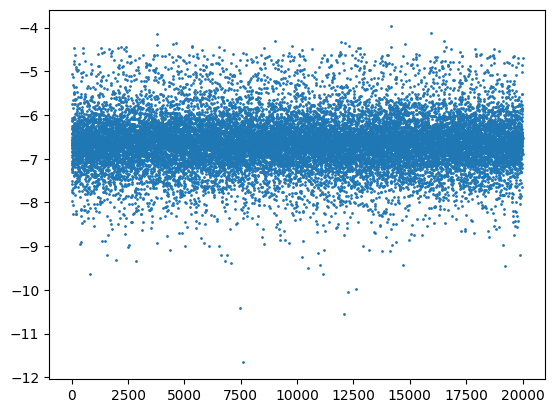

In [107]:
plt.scatter(np.arange(len(data_list)), y2s, s=1)

In [133]:
right = 0
wrong = 0
ok =0
errors2 = []
std = np.std(y2s)
for s in data_test2:
  model2.eval()
  pred = model2(s.enc)
  #print(pred.detach().numpy(), s.y.numpy())
  error = np.abs(pred.detach().numpy()-s.y2.numpy())
  errors2.append(error)

  if error <std/5:
    right+=1
  elif error<std/2:
    ok+=1
  else:
    wrong+=1
print(right, ok, wrong)

849 941 710


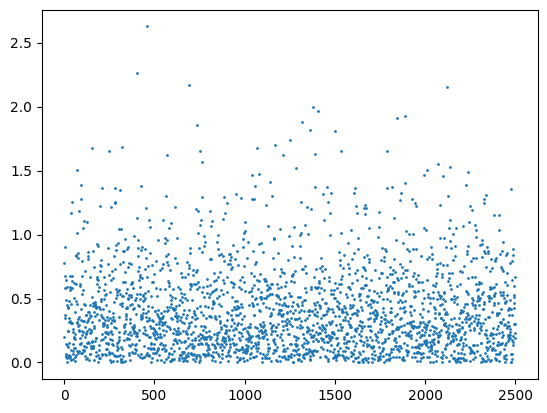

In [109]:
plt.scatter(np.arange(len(errors2)),errors2/std, s=1)

In [124]:
random.shuffle(data_list)

In [125]:
data_train3 = data_list[:15000]
data_val3 = data_list[15000:17500]
data_test3 = data_list[17500:]
loaded_train3 = DataLoader(data_train3, batch_size=50, shuffle=True)
loaded_val3 = DataLoader(data_val3, batch_size=50, shuffle=True)
loaded_test3 = DataLoader(data_test3, batch_size=50, shuffle=True)
model3 = predictor()
#optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
print(model3)


predictor(
  (regression): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [126]:
def train3(b):
  p = model3(b.enc)
  #print(np.shape(p))
  #print(b.enc)
  #print(p)
  l = loss_fn(p, b.y3.reshape((50,1)))
  #print(b.y1.reshape((50,1)))
  #print(pred)
  optimizer.zero_grad()
  l.backward()
  optimizer.step()
  return l.detach()
def test3(b):
  p = model3(b.enc)
  l = loss_fn(p, b.y3.reshape((50,1)))
  return l.detach()

In [127]:
loss_log3 = []
loss_log_val3 = []
for epoch in range(500):
  tl = 0
  tl_val=0
  model3.train()
  for b in loaded_train3:
    l =  train3(b)
    tl += l
  model3.eval()
  for b in loaded_val3:
    l = test3(b)
    tl_val += l
  print(tl/len(loaded_train3))
  print(tl_val/len(loaded_val3))
  loss_log3.append(tl/len(loaded_train3))
  loss_log_val3.append(tl_val/len(loaded_val3))
  if epoch%10==9:
    plt.plot(loss_log3[1:])
    plt.plot(loss_log_val3[1:])
    plt.show()

AttributeError: 'GlobalStorage' object has no attribute 'enc'

tensor(5.2654)
tensor(-4.5171)
0.52496433
1.2790931
0.5551123


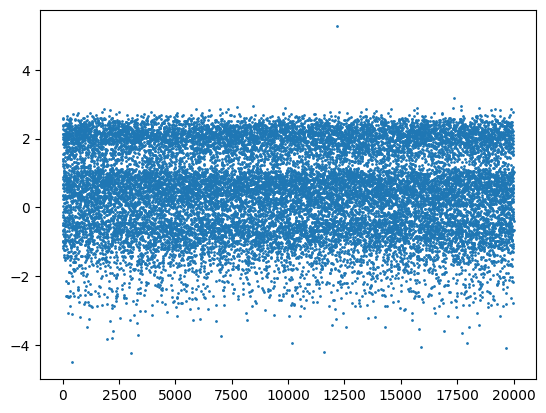

In [132]:
y3s = [s.y3 for s in data_list]
print(max(y3s))
print(min(y3s))
print(np.mean(y3s))
print(np.std(y3s))
print(np.median(y3s))
plt.scatter(np.arange(len(data_list)), y3s, s=1)

In [ ]:
right = 0
wrong = 0
ok =0
errors3 = []
std = np.std(y3s)
for s in data_test3:
  model3.eval()
  pred = model3(s.enc)
  #print(pred.detach().numpy(), s.y.numpy())
  error = np.abs(pred.detach().numpy()-s.y3.numpy())
  errors3.append(error)

  if error <std/5:
    right+=1
  elif error<std/2:
    ok+=1
  else:
    wrong+=1
print(right, ok, wrong)

In [ ]:
plt.scatter(np.arange(len(errors3)),errors3/np.std(y3s), s=1)
plt.show()